# ML vs non-ML Pylint Exploration

Dependencies:
- analyse_py_ver notebook (best_guess.csv)

This notebook:

- Marks repos as ML/non-ML based on fraction of ML modules.
- Merges various sources into a single dataframe
- Normalises the number of Pylint Errors based on the number of SLOC (Source Linces of Code)
- Visualises the results for each type of Pylint Error/Warning, broken down by ML/non-ML
- Visualises the results for each type of Pylint Error/Warning, broken down by category (ML0, ML1, ML2, ML3, ML4)
- Ranks Pylint Errors/Warnings by the significance of the difference between messages for ML/non-ML repos

In [1]:
from os.path import join
import pandas as pd
import numpy as np
import scipy.stats as stats
import altair as alt # Python wrapper for Vega-Lite visualisation grammarimport altair as alt
from altair import datum

In [2]:
DATA_DIR = "../output/"

In [3]:
# https://altair-viz.github.io/user_guide/faq.html#altair-faq-large-notebook
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Label Repo Type

In [4]:
proj_labels = pd.read_csv("proj_labels.csv")
#https://stackoverflow.com/questions/12860421/python-pandas-pivot-table-with-aggfunc-count-unique-distinct
proj_labels_pivot = pd.pivot_table(proj_labels, values="path", index="repo", columns="cat", aggfunc=pd.Series.nunique)
proj_labels_pivot = proj_labels_pivot.fillna(0)

In [5]:
proj_labels_pivot

cat         ml0  ml1  ml2  ml3  ml4  other  test
repo                                            
41590       0.0  0.0  0.0  0.0  0.0   22.0   7.0
118130     16.0  0.0  0.0  0.0  0.0   27.0   2.0
550482      0.0  0.0  0.0  0.0  0.0   10.0   3.0
590142      0.0  0.0  0.0  0.0  0.0  610.0  22.0
607040      0.0  0.0  0.0  0.0  0.0    1.0   0.0
...         ...  ...  ...  ...  ...    ...   ...
112664267  31.0  2.0  1.0  1.0  0.0    9.0   0.0
114098658  26.0  1.0  2.0  0.0  0.0   13.0   0.0
115672915  47.0  1.0  0.0  0.0  0.0   26.0   0.0
118248283  14.0  0.0  0.0  0.0  0.0    4.0   0.0
119537109  21.0  8.0  0.0  0.0  0.0   43.0   0.0

[222 rows x 7 columns]

In [6]:
proj_labels_pivot["total"] = proj_labels_pivot.apply("sum", axis=1)
proj_labels_pivot["frac_ml"] = proj_labels_pivot["ml0"] / proj_labels_pivot["total"]

In [7]:
proj_labels_pivot.sort_values("frac_ml", ascending=False)

cat        ml0  ml1  ml2  ml3  ml4  other  test  total  frac_ml
repo                                                           
53430164   4.0  0.0  0.0  0.0  0.0    0.0   0.0    4.0      1.0
69533102   1.0  0.0  0.0  0.0  0.0    0.0   0.0    1.0      1.0
21574434   1.0  0.0  0.0  0.0  0.0    0.0   0.0    1.0      1.0
67244718   1.0  0.0  0.0  0.0  0.0    0.0   0.0    1.0      1.0
109562178  3.0  0.0  0.0  0.0  0.0    0.0   0.0    3.0      1.0
...        ...  ...  ...  ...  ...    ...   ...    ...      ...
17856536   0.0  0.0  0.0  0.0  0.0  498.0  24.0  522.0      0.0
18617947   0.0  0.0  0.0  0.0  0.0    1.0   0.0    1.0      0.0
18633922   0.0  0.0  0.0  0.0  0.0    3.0   0.0    3.0      0.0
41890193   0.0  0.0  0.0  0.0  0.0   20.0   0.0   20.0      0.0
41590      0.0  0.0  0.0  0.0  0.0   22.0   7.0   29.0      0.0

[222 rows x 9 columns]

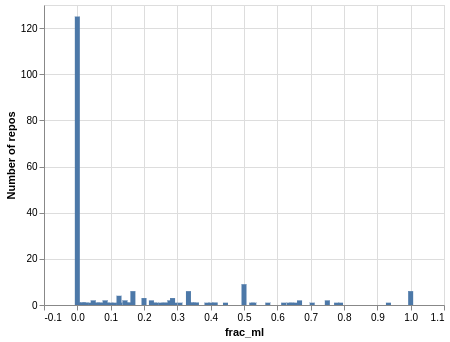

In [8]:
chart = alt.Chart(proj_labels_pivot).mark_bar().encode(
    x = alt.X('frac_ml', type='quantitative', title="frac_ml", scale=alt.Scale(domain=(0,1))),
    y = alt.Y('count()', title="Number of repos"),
)
chart

In [9]:
chart.save("proj_labels_pivot.svg")

We declare any repos with at least 10% of modules containing an import of an ML library as being ML. E.g. if there are 20 modules, and at least two import an ML library such as Tensorflow, the repo will be marked as ML.

This threshold helps ensure that the project is genuinely ML code, rather than just a large repo that happens to contain a few ML examples.

In [10]:
proj_labels_pivot["is_ml_repo"] = proj_labels_pivot["frac_ml"] >= 0.1

In [11]:
proj_labels_pivot

cat         ml0  ml1  ml2  ml3  ml4  other  test  total   frac_ml  is_ml_repo
repo                                                                         
41590       0.0  0.0  0.0  0.0  0.0   22.0   7.0   29.0  0.000000       False
118130     16.0  0.0  0.0  0.0  0.0   27.0   2.0   45.0  0.355556        True
550482      0.0  0.0  0.0  0.0  0.0   10.0   3.0   13.0  0.000000       False
590142      0.0  0.0  0.0  0.0  0.0  610.0  22.0  632.0  0.000000       False
607040      0.0  0.0  0.0  0.0  0.0    1.0   0.0    1.0  0.000000       False
...         ...  ...  ...  ...  ...    ...   ...    ...       ...         ...
112664267  31.0  2.0  1.0  1.0  0.0    9.0   0.0   44.0  0.704545        True
114098658  26.0  1.0  2.0  0.0  0.0   13.0   0.0   42.0  0.619048        True
115672915  47.0  1.0  0.0  0.0  0.0   26.0   0.0   74.0  0.635135        True
118248283  14.0  0.0  0.0  0.0  0.0    4.0   0.0   18.0  0.777778        True
119537109  21.0  8.0  0.0  0.0  0.0   43.0   0.0   72.0  0.291667        True

[222 rows x 10 columns]

In [12]:
proj_labels_pivot["is_ml_repo"].value_counts()

False    141
True      81
Name: is_ml_repo, dtype: int64

## Python Version

We extract a list of Python2 repos, and a list of Python3 repos

In [12]:
best_guess_df = pd.read_csv("best_guess.csv")

In [13]:
py2_repos = best_guess_df[best_guess_df["bestguess"] == "py2"]["repo"].unique()

In [14]:
py2_repos

array([    41590,    118130,    550482,    590142,    607040,    759484,
          791699,    838999,   1383879,   1465795,   1730849,   2000318,
         2240410,   2660382,   2926406,   3129447,   3277926,   3287642,
         3546355,   3932246,   4035165,   4066562,   6125281,   6291757,
         6465727,   6532318,   6859723,   6972160,   8189818,   8194692,
         8373425,   8408538,   8424376,   8776176,   8832136,   9530414,
         9651619,   9996540,  10224745,  10404901,  11075275,  11414686,
        11469390,  12086903,  12161605,  12275225,  12494124,  13210816,
        13570500,  13884324,  13970869,  14161890,  14284950,  15112920,
        15120191,  15221621,  15674392,  15899135,  15985050,  16227240,
        16742762,  17639957,  17856536,  18617947,  18633922,  18960265,
        19160523,  19346982,  19703420,  20021753,  20090068,  21037072,
        21574434,  23103659,  23129008,  23409750,  23579369,  26118292,
        26595015,  27339738,  27731143,  27888002, 

In [15]:
py3_repos = best_guess_df[best_guess_df["bestguess"] == "py3"]["repo"].unique()

In [16]:
py3_repos

array([  3255194,   5651850,  13261025,  15247930,  18766036,  19057465,
        20030361,  21438190,  21467110,  22354028,  23770267,  24100479,
        25234558,  26073196,  27677040,  30111238,  34639031,  35187829,
        36151086,  38108816,  38463323,  40087278,  41890193,  44304626,
        44606420,  46801369,  46939261,  48450890,  52581991,  53941799,
        57212617,  60109178,  61813823,  62956639,  63867447,  70118622,
        70148832,  72225778,  76041801,  76262719,  77101262,  77662713,
        78097444,  78508757,  79748320,  80504468,  81585787,  83399665,
        89879629,  89886473,  91313284,  91356408,  91599679,  92235513,
        92270845,  92591596,  93305304,  96111593,  97074218,  97207348,
        97508182,  99785600, 100073601, 103471501, 108704309, 109562178,
       111079817, 111696541, 112664267, 114098658, 118248283, 119537109])

In [17]:
# Should have nothing in common
set(py2_repos) & set(py3_repos)

set()

In [18]:
len(py2_repos) + len(py3_repos)

222

## Merge Python2 and Python3 Pylint results

We select Pylint results based on the best guess of the Python version

In [19]:
lint_df_py2 = pd.read_csv(join(DATA_DIR, "results_pylint_python2.csv"))
lint_df_py3 = pd.read_csv(join(DATA_DIR, "results_pylint_python3.csv"))
lint_df_py2_sel = lint_df_py2[lint_df_py2["repo"].isin(py2_repos)]
lint_df_py3_sel = lint_df_py3[lint_df_py3["repo"].isin(py3_repos)]
lint_df_combo = pd.concat([lint_df_py2_sel, lint_df_py3_sel])

In [20]:
lint_df_combo.repo.nunique()

222

In [21]:
lint_df_combo

repo                              path        type  \
1530    56709482  56709482/csv_monkey_converter.py  convention   
1531    56709482  56709482/csv_monkey_converter.py       error   
1532    56709482  56709482/csv_monkey_converter.py  convention   
1533    56709482  56709482/csv_monkey_converter.py  convention   
1534    56709482  56709482/csv_monkey_converter.py  convention   
...          ...                               ...         ...   
576878  62956639       62956639/models/char_tcn.py  convention   
576879  62956639       62956639/models/char_tcn.py  convention   
576880  62956639       62956639/models/char_tcn.py  convention   
576881  62956639       62956639/models/char_tcn.py  convention   
576882  62956639       62956639/models/char_tcn.py    refactor   

                      module                   obj  line  column  \
1530    csv_monkey_converter                   NaN   1.0     0.0   
1531    csv_monkey_converter                   NaN   1.0     0.0   
1532    csv_monkey_converter                   NaN   5.0     0.0   
1533    csv_monkey_converter                   NaN  12.0     0.0   
1534    csv_monkey_converter             get_class  18.0     0.0   
...                      ...                   ...   ...     ...   
576878       models.char_tcn  CharTCN._build_model  73.0    12.0   
576879       models.char_tcn  CharTCN._build_model  74.0    12.0   
576880       models.char_tcn  CharTCN._build_model  75.0    12.0   
576881       models.char_tcn  CharTCN._build_model  76.0    12.0   
576882       models.char_tcn         CharTCN.train  86.0     4.0   

                         path.1              symbol  \
1530    csv_monkey_converter.py   missing-docstring   
1531    csv_monkey_converter.py        import-error   
1532    csv_monkey_converter.py        invalid-name   
1533    csv_monkey_converter.py        invalid-name   
1534    csv_monkey_converter.py   missing-docstring   
...                         ...                 ...   
576878       models/char_tcn.py        invalid-name   
576879       models/char_tcn.py        invalid-name   
576880       models/char_tcn.py        invalid-name   
576881       models/char_tcn.py        invalid-name   
576882       models/char_tcn.py  too-many-arguments   

                                                  message message-id  \
1530                             Missing module docstring      C0111   
1531                            Unable to import 'pandas'      E0401   
1532    Constant name "df" doesn't conform to UPPER_CA...      C0103   
1533    Constant name "df" doesn't conform to UPPER_CA...      C0103   
1534                           Missing function docstring      C0111   
...                                                   ...        ...   
576878  Variable name "fl" doesn't conform to snake_ca...      C0103   
576879  Variable name "x" doesn't conform to snake_cas...      C0103   
576880  Variable name "x" doesn't conform to snake_cas...      C0103   
576881  Variable name "x" doesn't conform to snake_cas...      C0103   
576882                           Too many arguments (8/5)      R0913   

        parse_error  internal_error  
1530          False           False  
1531          False           False  
1532          False           False  
1533          False           False  
1534          False           False  
...             ...             ...  
576878        False           False  
576879        False           False  
576880        False           False  
576881        False           False  
576882        False           False  

[687030 rows x 13 columns]

## Merge Python2 and Python3 Radon raw results (SLOC)

In [22]:
raw_df_py2 = pd.read_csv(join(DATA_DIR, "results_radon_raw_python2.csv"))

In [23]:
raw_df_py2["ver"] = "py2"

In [24]:
raw_df_py3 = pd.read_csv(join(DATA_DIR, "results_radon_raw_python3.csv"))

In [25]:
raw_df_py3["ver"] = "py3"

In [26]:
raw_df_py2_sel = raw_df_py2[raw_df_py2["repo"].isin(py2_repos)]

In [27]:
raw_df_py3_sel = raw_df_py3[raw_df_py3["repo"].isin(py3_repos)]

In [28]:
raw_df_combo = pd.concat([raw_df_py2_sel, raw_df_py3_sel])

In [29]:
raw_df_combo.repo.nunique()

222

In [30]:
raw_df_combo

repo                                  path    loc  lloc  sloc  \
31    56709482      56709482/csv_monkey_converter.py   31.0  14.0  14.0   
32    56709482          56709482/opinionTokenizer.py   72.0  50.0  50.0   
33    56709482     56709482/hotel_sentiment/items.py   41.0  27.0  27.0   
34    56709482  56709482/hotel_sentiment/__init__.py    0.0   0.0   0.0   
35    56709482  56709482/hotel_sentiment/settings.py   84.0   3.0   3.0   
...        ...                                   ...    ...   ...   ...   
7817  62956639                62956639/data_utils.py   88.0  52.0  48.0   
7818  62956639     62956639/models/char_cnn_zhang.py  125.0  51.0  59.0   
7819  62956639           62956639/models/__init__.py    0.0   0.0   0.0   
7820  62956639       62956639/models/char_cnn_kim.py  127.0  48.0  59.0   
7821  62956639           62956639/models/char_tcn.py  132.0  58.0  66.0   

      comments  multi  blank  single_comments  parse_error  internal_error  \
31         9.0    0.0    8.0              9.0        False           False   
32        15.0    0.0    7.0             15.0        False           False   
33         4.0    0.0   10.0              4.0        False           False   
34         0.0    0.0    0.0              0.0        False           False   
35        65.0    0.0   16.0             65.0        False           False   
...        ...    ...    ...              ...          ...             ...   
7817       2.0   27.0   13.0              0.0        False           False   
7818      11.0   42.0   14.0             10.0        False           False   
7819       0.0    0.0    0.0              0.0        False           False   
7820      11.0   43.0   15.0             10.0        False           False   
7821      15.0   41.0   13.0             12.0        False           False   

      ver  
31    py2  
32    py2  
33    py2  
34    py2  
35    py2  
...   ...  
7817  py3  
7818  py3  
7819  py3  
7820  py3  
7821  py3  

[7941 rows x 12 columns]

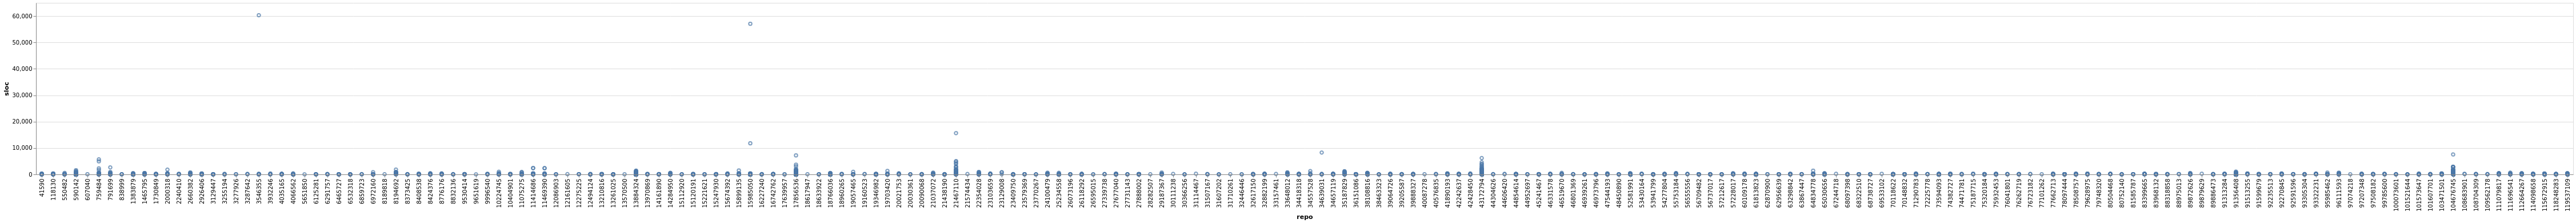

In [31]:
chart = alt.Chart(raw_df_combo).mark_point().encode(
    x = alt.X('repo', type='nominal'),
    y = alt.Y('sloc', title="sloc")
)
chart

In [32]:
chart.save("sloc-vs-repo.png")

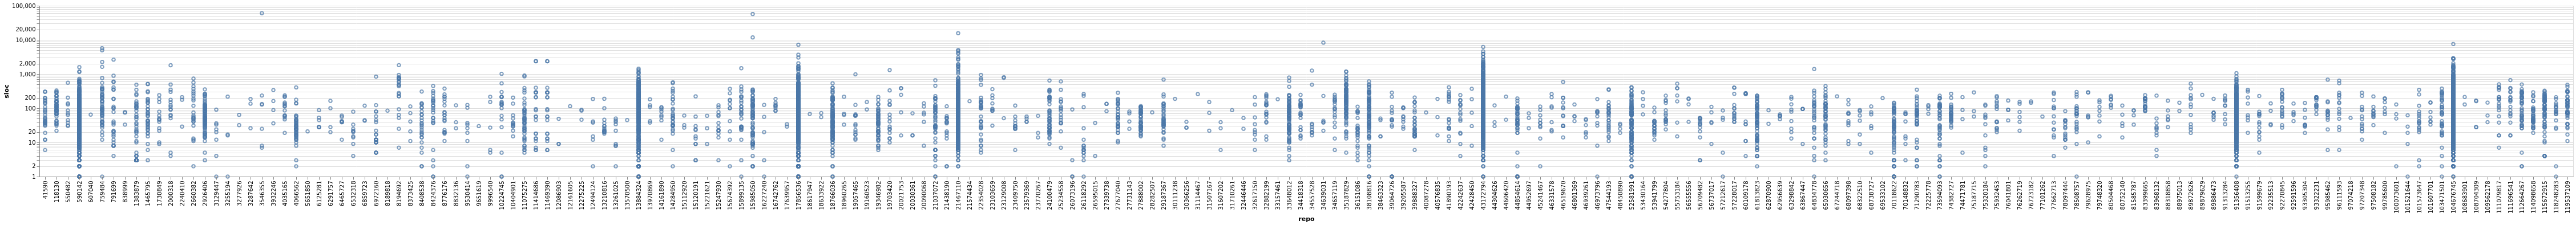

In [33]:
chart = alt.Chart(raw_df_combo).mark_point().encode(
    x = alt.X('repo', type='nominal'),
    y = alt.Y('sloc', scale=alt.Scale(type="log"), title="sloc")
).transform_filter(
    (datum.sloc > 0)
)
chart

In [34]:
chart.save("sloc-vs-repo-logscale.png")

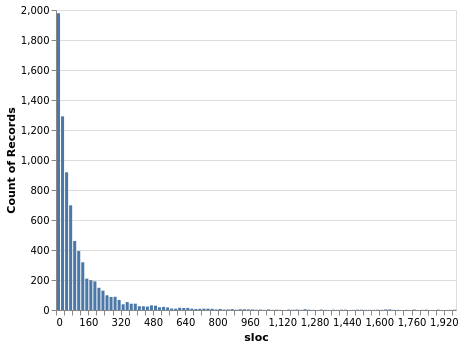

In [35]:
chart = alt.Chart(raw_df_combo).mark_bar().encode(
    x = alt.X('sloc:Q', title="sloc", bin={'maxbins': 100}),
    y = 'count()'
).transform_filter(
    (datum.sloc < 2000) # set cut-off here to make it easier to see distribution
)
chart

In [36]:
chart.save("dist-sloc.png")

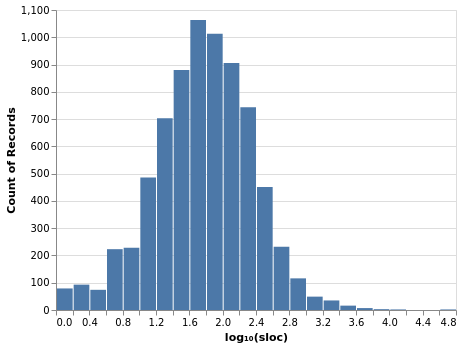

In [37]:
chart = alt.Chart(raw_df_combo).mark_bar().encode(
    x = alt.X('x:Q', title="log₁₀(sloc)", bin={'maxbins': 30}),
    y = 'count()'
).transform_filter(
    (datum.sloc > 0)
).transform_calculate(
    x = 'log(datum.sloc)/LN10' # convert JS logₑ to log₁₀
)
chart

In [38]:
chart.save("dist-sloc-logscale.png")

In [39]:
raw_df_combo.sloc.describe()

count     7907.000000
mean       148.444290
std       1009.654329
min          0.000000
25%         19.000000
50%         54.000000
75%        130.000000
max      60312.000000
Name: sloc, dtype: float64

SLOC appear to be log-normally distrubted

## Merge Python2 and Python3 Cyclomatic complexity results

In [40]:
df_cc2 = pd.read_csv(join(DATA_DIR, "results_radon_cc_python2.csv"))
df_cc3 = pd.read_csv(join(DATA_DIR, "results_radon_cc_python3.csv"))
df_cc2_sel = df_cc2[df_cc2["repo"].isin(py2_repos)]
df_cc3_sel = df_cc3[df_cc3["repo"].isin(py3_repos)]
df_cc_combo = pd.concat([df_cc2_sel, df_cc3_sel])

In [41]:
df_cc_combo

repo                               path      type rank  lineno  \
187    56709482   56709482/csv_monkey_converter.py  function    A    18.0   
188    56709482       56709482/opinionTokenizer.py  function    A    17.0   
189    56709482       56709482/opinionTokenizer.py  function    A     6.0   
190    56709482  56709482/hotel_sentiment/items.py     class    A    10.0   
191    56709482  56709482/hotel_sentiment/items.py     class    A    15.0   
...         ...                                ...       ...  ...     ...   
65630  62956639        62956639/models/char_tcn.py    method    A    46.0   
65631  62956639        62956639/models/char_tcn.py     class    A    12.0   
65632  62956639        62956639/models/char_tcn.py    method    A    17.0   
65633  62956639        62956639/models/char_tcn.py    method    A    86.0   
65634  62956639        62956639/models/char_tcn.py    method    A   118.0   

                                name  col_offset  complexity  endline  \
187                        get_class         0.0         2.0     23.0   
188    positive_and_negative_to_full         0.0         5.0     33.0   
189      tokenize_into_opinion_units         0.0         3.0     11.0   
190               HotelSentimentItem         0.0         1.0     13.0   
191            TripAdvisorReviewItem         0.0         1.0     33.0   
...                              ...         ...         ...      ...   
65630                   _build_model         4.0         4.0     84.0   
65631                        CharTCN         0.0         3.0    131.0   
65632                       __init__         4.0         1.0     44.0   
65633                          train         4.0         1.0    116.0   
65634                           test         4.0         1.0    131.0   

       methods_count  closures_count  parse_error  internal_error  
187              0.0             0.0        False           False  
188              0.0             0.0        False           False  
189              0.0             0.0        False           False  
190              0.0             0.0        False           False  
191              0.0             0.0        False           False  
...              ...             ...          ...             ...  
65630            0.0             0.0        False           False  
65631            4.0             0.0        False           False  
65632            0.0             0.0        False           False  
65633            0.0             0.0        False           False  
65634            0.0             0.0        False           False  

[78207 rows x 13 columns]

In [42]:
# ignore classes (are just average of methods), empty (e.g. __init__), errors, etc.
df_cc_combo_filt = df_cc_combo[df_cc_combo["type"].isin(["method", "function"])]

In [43]:
df_cc_combo_filt["parse_error"].value_counts()

False    65148
Name: parse_error, dtype: int64

In [44]:
df_cc_combo_filt["internal_error"].value_counts()

False    65148
Name: internal_error, dtype: int64

In [45]:
df_cc_combo_filt

repo                                               path      type  \
187    56709482                   56709482/csv_monkey_converter.py  function   
188    56709482                       56709482/opinionTokenizer.py  function   
189    56709482                       56709482/opinionTokenizer.py  function   
196    56709482              56709482/hotel_sentiment/pipelines.py    method   
198    56709482  56709482/hotel_sentiment/spiders/tripadvisor_s...    method   
...         ...                                                ...       ...   
65629  62956639                    62956639/models/char_cnn_kim.py    method   
65630  62956639                        62956639/models/char_tcn.py    method   
65632  62956639                        62956639/models/char_tcn.py    method   
65633  62956639                        62956639/models/char_tcn.py    method   
65634  62956639                        62956639/models/char_tcn.py    method   

      rank  lineno                           name  col_offset  complexity  \
187      A    18.0                      get_class         0.0         2.0   
188      A    17.0  positive_and_negative_to_full         0.0         5.0   
189      A     6.0    tokenize_into_opinion_units         0.0         3.0   
196      A     9.0                   process_item         4.0         1.0   
198      A    27.0                    parse_hotel         4.0         3.0   
...    ...     ...                            ...         ...         ...   
65629    A   113.0                           test         4.0         1.0   
65630    A    46.0                   _build_model         4.0         4.0   
65632    A    17.0                       __init__         4.0         1.0   
65633    A    86.0                          train         4.0         1.0   
65634    A   118.0                           test         4.0         1.0   

       endline  methods_count  closures_count  parse_error  internal_error  
187       23.0            0.0             0.0        False           False  
188       33.0            0.0             0.0        False           False  
189       11.0            0.0             0.0        False           False  
196       10.0            0.0             0.0        False           False  
198       43.0            0.0             0.0        False           False  
...        ...            ...             ...          ...             ...  
65629    126.0            0.0             0.0        False           False  
65630     84.0            0.0             0.0        False           False  
65632     44.0            0.0             0.0        False           False  
65633    116.0            0.0             0.0        False           False  
65634    131.0            0.0             0.0        False           False  

[65148 rows x 13 columns]

In [46]:
complexity_df = pd.DataFrame(df_cc_combo_filt.groupby(["repo", "path"]).mean()["complexity"])
complexity_df

complexity
repo      path                                            
41590     41590/nlp/counter.py                    2.620690
          41590/nlp/countermap.py                 2.904762
          41590/nlp/crp.py                        2.285714
          41590/nlp/distributions.py              2.142857
          41590/nlp/features.py                   9.500000
...                                                    ...
119537109 119537109/utils/oracle/OracleGru.py     1.666667
          119537109/utils/oracle/OracleLstm.py    2.142857
          119537109/utils/oracle/OracleSru.py     1.666667
          119537109/utils/text_process.py         3.000000
          119537109/utils/utils.py                3.666667

[5930 rows x 1 columns]

In [47]:
complexity_df["complexity"].describe()

count    5930.000000
mean        3.644640
std         3.857683
min         1.000000
25%         1.750000
50%         2.779514
75%         4.250000
max       147.000000
Name: complexity, dtype: float64

In [48]:
best_guess_df

repo  either  neither  python2  python3  summary  py2penalty  \
0        41590    12.0      1.0     16.0      0.0  neither      3261.0   
1       118130    16.0      0.0     28.0      1.0      mix      3580.0   
2       550482    11.0      0.0      2.0      0.0    only2       510.0   
3       590142   501.0      0.0    131.0      0.0    only2     30534.0   
4       607040     0.0      0.0      1.0      0.0    only2        50.0   
..         ...     ...      ...      ...      ...      ...         ...   
217  112664267    43.0      0.0      0.0      1.0    only3      3147.0   
218  114098658    40.0      0.0      0.0      2.0    only3      3059.0   
219  115672915    73.0      0.0      1.0      0.0    only2      1813.0   
220  118248283    18.0      0.0      0.0      0.0   either       988.0   
221  119537109    71.0      0.0      0.0      1.0    only3      2929.0   

     py3penalty pylint_summary bestguess  
0         856.0            py3       py2  
1        1737.0            py3       py2  
2         475.0            py3       py2  
3       18017.0            py3       py2  
4           5.0            py3       py2  
..          ...            ...       ...  
217      3017.0            py3       py3  
218      3094.0            py2       py3  
219      1816.0            py2       py2  
220       972.0            py3       py3  
221      2667.0            py3       py3  

[222 rows x 10 columns]

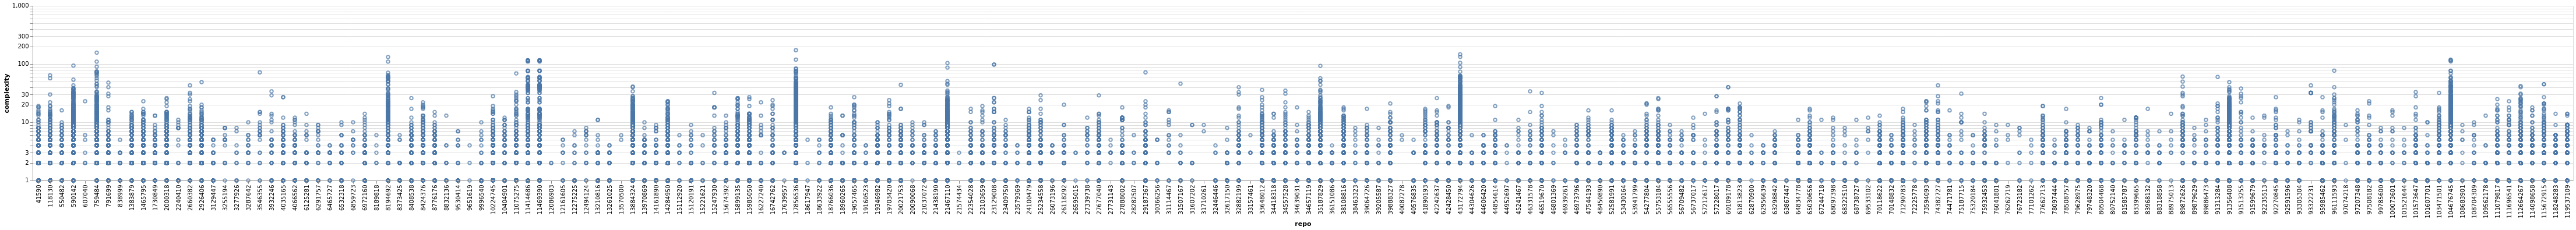

In [49]:
chart = alt.Chart(df_cc_combo).mark_point().encode(
    x = alt.X('repo', type='nominal'),
    y = alt.Y('complexity', scale=alt.Scale(type="log"), title="complexity")
).transform_filter(
    (datum.complexity > 0)
)
chart

## Remove Files with Parse Errors from Analysis

In [50]:
lint_df_combo.parse_error.value_counts()

False    686926
True        104
Name: parse_error, dtype: int64

In [51]:
print(sorted(filter(lambda x: not pd.isnull(x), lint_df_combo["message-id"].unique())))

['C0102', 'C0103', 'C0111', 'C0112', 'C0113', 'C0114', 'C0115', 'C0116', 'C0121', 'C0122', 'C0123', 'C0200', 'C0201', 'C0202', 'C0203', 'C0204', 'C0205', 'C0301', 'C0302', 'C0303', 'C0304', 'C0305', 'C0321', 'C0325', 'C0326', 'C0330', 'C0410', 'C0411', 'C0412', 'C0413', 'C0414', 'C0415', 'C1001', 'C1801', 'E0001', 'E0012', 'E0101', 'E0102', 'E0107', 'E0110', 'E0202', 'E0203', 'E0211', 'E0213', 'E0237', 'E0301', 'E0302', 'E0401', 'E0402', 'E0601', 'E0602', 'E0603', 'E0604', 'E0611', 'E0632', 'E0633', 'E0701', 'E0702', 'E0704', 'E0711', 'E0712', 'E1002', 'E1003', 'E1004', 'E1101', 'E1102', 'E1111', 'E1120', 'E1121', 'E1123', 'E1124', 'E1126', 'E1127', 'E1128', 'E1130', 'E1133', 'E1135', 'E1136', 'E1137', 'E1139', 'E1200', 'E1205', 'E1300', 'E1305', 'E1306', 'E1307', 'F0001', 'R0123', 'R0124', 'R0201', 'R0202', 'R0203', 'R0205', 'R0901', 'R0902', 'R0903', 'R0904', 'R0911', 'R0912', 'R0913', 'R0914', 'R0915', 'R0916', 'R1701', 'R1702', 'R1703', 'R1704', 'R1705', 'R1706', 'R1707', 'R1708', 

In [52]:
lint_df_combo[lint_df_combo["parse_error"]].repo.value_counts()

76262719    86
4035165      2
46939261     1
20030361     1
30111238     1
74382727     1
34418318     1
41890193     1
32882199     1
17856536     1
71290783     1
41590        1
97508182     1
3932246      1
79748320     1
73594093     1
118130       1
99785600     1
Name: repo, dtype: int64

The "parse_error" column represents syntax errors (E0001). In some cases, the error can be triggered due to syntax errors in imported modules rather than the file itself.
We will remove these files from the analysis, as because if there is a syntax error, Pylint is usually unable to analyse the file any further. (If the syntax error is in an imported module, Pylint can continue, but will not be able to check usage of that module in the same depth).

In [53]:
lint_df_combo[lint_df_combo["internal_error"]].repo.value_counts()

2000318     1
13884324    1
Name: repo, dtype: int64

In [54]:
lint_df_combo[lint_df_combo["internal_error"]]

repo                             path type module  obj  line  \
90051   13884324  13884324/lib/jinja2/compiler.py  NaN    NaN  NaN   NaN   
286922   2000318                2000318/bottle.py  NaN    NaN  NaN   NaN   

        column path.1 symbol message message-id  parse_error  internal_error  
90051      NaN    NaN    NaN     NaN        NaN        False            True  
286922     NaN    NaN    NaN     NaN        NaN        False            True

In [55]:
lint_df_combo[lint_df_combo["internal_error"]].repo.isin(py2_repos).all()

True

The "internal error" column represents cases where the Pylint output was not valid JSON. Upon closer examination, it appears that if there are no errors (either because the file is empty, or because it perfectly follows conventions), then Pylint for Python2 returns no output ("") rather than an empty array ("[]"). This causes the analysis code to flag an internal error when parsing the Pylint output.

**TODO:** Update Pylint code to work-around Pylint Python2 bug rather than treating as an internal error. (fixed 2020-01-28)

We remove any cases of parse errors or internal errors:

In [56]:
lint_df_combo_clean = lint_df_combo[~lint_df_combo["parse_error"] & ~lint_df_combo["internal_error"]]

In [57]:
lint_df_combo_clean[pd.isnull(lint_df_combo_clean["module"])]

repo                                          path type module  \
1567    56709482          56709482/hotel_sentiment/__init__.py  NaN    NaN   
1603    56709482  56709482/hotel_sentiment/spiders/__init__.py  NaN    NaN   
2161     8408538                 8408538/east/asts/__init__.py  NaN    NaN   
2168     8408538             8408538/east/synonyms/__init__.py  NaN    NaN   
2212     8408538                  8408538/analysis/__init__.py  NaN    NaN   
...          ...                                           ...  ...    ...   
543750  61813823           61813823/pythainlp/util/__init__.py  NaN    NaN   
543798  61813823           61813823/pythainlp/util/keyboard.py  NaN    NaN   
543841  61813823           61813823/pythainlp/tag/locations.py  NaN    NaN   
543895  61813823          61813823/pythainlp/tools/__init__.py  NaN    NaN   
576828  62956639                   62956639/models/__init__.py  NaN    NaN   

        obj  line  column path.1 symbol message message-id  parse_error  \
1567    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
1603    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
2161    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
2168    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
2212    NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
...     ...   ...     ...    ...    ...     ...        ...          ...   
543750  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
543798  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
543841  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
543895  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   
576828  NaN   NaN     NaN    NaN    NaN     NaN        NaN        False   

        internal_error  
1567             False  
1603             False  
2161             False  
2168             False  
2212             False  
...                ...  
543750           False  
543798           False  
543841           False  
543895           False  
576828           False  

[524 rows x 13 columns]

The above rows represent cases where there were no Pylint errrors. This can be because either the file is empty (e.g. an empty __init__.py), or because the file had no issues (e.g. `61813823/pythainlp/util/keyboard.py` -- note `61813823/.circleci/config.yml` shows that this repo did a flake8 lint test as part of the CI process). These files were left in the analysis.

## Merge results into combined Data Frame

In [58]:
lint_df_modules = lint_df_combo_clean[['repo', 'path', 'symbol', 'message-id']].pivot_table(index=['repo', 'path'], columns='symbol', aggfunc='count')
# Flatten columns, and add prefix 'lint_'
lint_df_modules.columns = ["lint_" + c for c in lint_df_modules.columns.get_level_values(1)]
lint_df_modules

lint_abstract-class-instantiated  \
repo      path                                                                     
41590     41590/nlp/counter.py                                               NaN   
          41590/nlp/countermap.py                                            NaN   
          41590/nlp/crp.py                                                   NaN   
          41590/nlp/cythonsetup.py                                           NaN   
          41590/nlp/distributions.py                                         NaN   
...                                                                          ...   
119537109 119537109/utils/oracle/OracleGru.py                                NaN   
          119537109/utils/oracle/OracleLstm.py                               NaN   
          119537109/utils/oracle/OracleSru.py                                NaN   
          119537109/utils/text_process.py                                    NaN   
          119537109/utils/utils.py                                           NaN   

                                                lint_abstract-method  \
repo      path                                                         
41590     41590/nlp/counter.py                                   NaN   
          41590/nlp/countermap.py                                NaN   
          41590/nlp/crp.py                                       NaN   
          41590/nlp/cythonsetup.py                               NaN   
          41590/nlp/distributions.py                             NaN   
...                                                              ...   
119537109 119537109/utils/oracle/OracleGru.py                    NaN   
          119537109/utils/oracle/OracleLstm.py                   NaN   
          119537109/utils/oracle/OracleSru.py                    NaN   
          119537109/utils/text_process.py                        NaN   
          119537109/utils/utils.py                               NaN   

                                                lint_access-member-before-definition  \
repo      path                                                                         
41590     41590/nlp/counter.py                                                   NaN   
          41590/nlp/countermap.py                                                NaN   
          41590/nlp/crp.py                                                       NaN   
          41590/nlp/cythonsetup.py                                               NaN   
          41590/nlp/distributions.py                                             NaN   
...                                                                              ...   
119537109 119537109/utils/oracle/OracleGru.py                                    NaN   
          119537109/utils/oracle/OracleLstm.py                                   NaN   
          119537109/utils/oracle/OracleSru.py                                    NaN   
          119537109/utils/text_process.py                                        NaN   
          119537109/utils/utils.py                                               NaN   

                                                lint_anomalous-backslash-in-string  \
repo      path                                                                       
41590     41590/nlp/counter.py                                                 NaN   
          41590/nlp/countermap.py                                              NaN   
          41590/nlp/crp.py                                                     NaN   
          41590/nlp/cythonsetup.py                                             NaN   
          41590/nlp/distributions.py                                           NaN   
...                                                                            ...   
119537109 119537109/utils/oracle/OracleGru.py                                  NaN   
          119537109/utils/oracle/OracleLstm.py                                 NaN   
          119

In [59]:
lint_df_modules_merged = lint_df_modules.merge(raw_df_combo, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...    loc   lloc  \
0                            NaN                      NaN  ...  255.0  176.0   
1                            NaN                      NaN  ...  213.0  148.0   
2                            NaN                      NaN  ...   70.0   44.0   
3                            NaN                      NaN  ...    8.0    5.0   
4                            NaN                      NaN  ...  103.0   65.0   
...                          ...                      ...  ...    ...    ...   
7389                         NaN                  

In [60]:
lint_df_modules_merged2 = lint_df_modules_merged.merge(proj_labels, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged2

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...   lloc   sloc  \
0                            NaN                      NaN  ...  176.0  172.0   
1                            NaN                      NaN  ...  148.0  145.0   
2                            NaN                      NaN  ...   44.0   42.0   
3                            NaN                      NaN  ...    5.0    6.0   
4                            NaN                      NaN  ...   65.0   64.0   
...                          ...                      ...  ...    ...    ...   
7389                         NaN                  

In [61]:
lint_df_modules_merged3 = lint_df_modules_merged2.merge(complexity_df, how='left', left_on=['repo', 'path'], right_on=['repo', 'path'])
lint_df_modules_merged3

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...   sloc  \
0                            NaN                      NaN  ...  172.0   
1                            NaN                      NaN  ...  145.0   
2                            NaN                      NaN  ...   42.0   
3                            NaN                      NaN  ...    6.0   
4                            NaN                      NaN  ...   64.0   
...                          ...                      ...  ...    ...   
7389                         NaN                      NaN  ...  147.0   
7390                      

In [62]:
lint_df_modules_merged_simp = lint_df_modules_merged3.merge(proj_labels_pivot, how='left', left_on='repo', right_on='repo')
lint_df_modules_merged_simp

repo                                  path  \
0         41590                  41590/nlp/counter.py   
1         41590               41590/nlp/countermap.py   
2         41590                      41590/nlp/crp.py   
3         41590              41590/nlp/cythonsetup.py   
4         41590            41590/nlp/distributions.py   
...         ...                                   ...   
7389  119537109   119537109/utils/oracle/OracleGru.py   
7390  119537109  119537109/utils/oracle/OracleLstm.py   
7391  119537109   119537109/utils/oracle/OracleSru.py   
7392  119537109       119537109/utils/text_process.py   
7393  119537109              119537109/utils/utils.py   

      lint_abstract-class-instantiated  lint_abstract-method  \
0                                  NaN                   NaN   
1                                  NaN                   NaN   
2                                  NaN                   NaN   
3                                  NaN                   NaN   
4                                  NaN                   NaN   
...                                ...                   ...   
7389                               NaN                   NaN   
7390                               NaN                   NaN   
7391                               NaN                   NaN   
7392                               NaN                   NaN   
7393                               NaN                   NaN   

      lint_access-member-before-definition  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   
...                                    ...   
7389                                   NaN   
7390                                   NaN   
7391                                   NaN   
7392                                   NaN   
7393                                   NaN   

      lint_anomalous-backslash-in-string  \
0                                    NaN   
1                                    NaN   
2                                    NaN   
3                                    NaN   
4                                    NaN   
...                                  ...   
7389                                 NaN   
7390                                 NaN   
7391                                 NaN   
7392                                 NaN   
7393                                 NaN   

      lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
0                                         NaN                    NaN   
1                                         NaN                    NaN   
2                                         NaN                    NaN   
3                                         NaN                    NaN   
4                                         NaN                    NaN   
...                                       ...                    ...   
7389                                      NaN                    NaN   
7390                                      NaN                    NaN   
7391                                      NaN                    NaN   
7392                                      NaN                    NaN   
7393                                      NaN                    NaN   

      lint_assign-to-new-keyword  lint_assigning-non-slot  ...   ml0  ml1  \
0                            NaN                      NaN  ...   0.0  0.0   
1                            NaN                      NaN  ...   0.0  0.0   
2                            NaN                      NaN  ...   0.0  0.0   
3                            NaN                      NaN  ...   0.0  0.0   
4                            NaN                      NaN  ...   0.0  0.0   
...                          ...                      ...  ...   ...  ...   
7389                         NaN                      NaN  ...  21.0  8

In [63]:
lint_df_modules_merged_simp.to_csv("lint_df_modules_merged_simp.csv")

In [64]:
list(lint_df_modules_merged_simp.columns)

['repo',
 'path',
 'lint_abstract-class-instantiated',
 'lint_abstract-method',
 'lint_access-member-before-definition',
 'lint_anomalous-backslash-in-string',
 'lint_anomalous-unicode-escape-in-string',
 'lint_arguments-differ',
 'lint_assign-to-new-keyword',
 'lint_assigning-non-slot',
 'lint_assignment-from-no-return',
 'lint_assignment-from-none',
 'lint_attribute-defined-outside-init',
 'lint_bad-classmethod-argument',
 'lint_bad-continuation',
 'lint_bad-except-order',
 'lint_bad-format-character',
 'lint_bad-indentation',
 'lint_bad-mcs-classmethod-argument',
 'lint_bad-mcs-method-argument',
 'lint_bad-option-value',
 'lint_bad-staticmethod-argument',
 'lint_bad-string-format-type',
 'lint_bad-super-call',
 'lint_bad-whitespace',
 'lint_bare-except',
 'lint_blacklisted-name',
 'lint_broad-except',
 'lint_catching-non-exception',
 'lint_cell-var-from-loop',
 'lint_chained-comparison',
 'lint_comparison-with-callable',
 'lint_comparison-with-itself',
 'lint_consider-iterating-dict

Summary: We merged everything into one big dataframe of features for exploration

## Exploration

### High Level

In [65]:
raw_df_combo

repo                                  path    loc  lloc  sloc  \
31    56709482      56709482/csv_monkey_converter.py   31.0  14.0  14.0   
32    56709482          56709482/opinionTokenizer.py   72.0  50.0  50.0   
33    56709482     56709482/hotel_sentiment/items.py   41.0  27.0  27.0   
34    56709482  56709482/hotel_sentiment/__init__.py    0.0   0.0   0.0   
35    56709482  56709482/hotel_sentiment/settings.py   84.0   3.0   3.0   
...        ...                                   ...    ...   ...   ...   
7817  62956639                62956639/data_utils.py   88.0  52.0  48.0   
7818  62956639     62956639/models/char_cnn_zhang.py  125.0  51.0  59.0   
7819  62956639           62956639/models/__init__.py    0.0   0.0   0.0   
7820  62956639       62956639/models/char_cnn_kim.py  127.0  48.0  59.0   
7821  62956639           62956639/models/char_tcn.py  132.0  58.0  66.0   

      comments  multi  blank  single_comments  parse_error  internal_error  \
31         9.0    0.0    8.0              9.0        False           False   
32        15.0    0.0    7.0             15.0        False           False   
33         4.0    0.0   10.0              4.0        False           False   
34         0.0    0.0    0.0              0.0        False           False   
35        65.0    0.0   16.0             65.0        False           False   
...        ...    ...    ...              ...          ...             ...   
7817       2.0   27.0   13.0              0.0        False           False   
7818      11.0   42.0   14.0             10.0        False           False   
7819       0.0    0.0    0.0              0.0        False           False   
7820      11.0   43.0   15.0             10.0        False           False   
7821      15.0   41.0   13.0             12.0        False           False   

      ver  
31    py2  
32    py2  
33    py2  
34    py2  
35    py2  
...   ...  
7817  py3  
7818  py3  
7819  py3  
7820  py3  
7821  py3  

[7941 rows x 12 columns]

In [66]:
repo_sloc_df = raw_df_combo.groupby(["repo"]).agg({"sloc": np.mean, "ver": lambda x: ";".join(pd.unique(x)) })

In [67]:
repo_sloc_df

sloc  ver
repo                      
41590       87.517241  py2
118130     123.288889  py2
550482     107.307692  py2
590142      77.789557  py2
607040      65.000000  py2
...               ...  ...
112664267  144.363636  py3
114098658   64.261905  py3
115672915  103.243243  py2
118248283   86.111111  py3
119537109   95.125000  py3

[222 rows x 2 columns]

In [68]:
repo_complexity_df = df_cc_combo.groupby("repo").mean()[["complexity"]]

In [69]:
repo_complexity_df

complexity
repo                 
41590        3.184314
118130       4.326590
550482       2.306452
590142       2.952619
607040       6.833333
...               ...
112664267    3.264014
114098658    2.950673
115672915    3.214022
118248283    2.556338
119537109    2.593182

[222 rows x 1 columns]

In [70]:
repo_complexity_df[~(repo_complexity_df["complexity"] > 0)]

complexity
repo                
5651850          NaN
20030361         NaN
23770267         NaN
30111238         NaN

In [71]:
# example of repo with no methods nor functions:
df_cc_combo[df_cc_combo["repo"] == 5651850]

repo              path type rank  lineno name  col_offset  \
31286  5651850  5651850/setup.py  NaN  NaN     NaN  NaN         NaN   

       complexity  endline  methods_count  closures_count  parse_error  \
31286         NaN      NaN            NaN             NaN        False   

       internal_error  
31286            True

In [72]:
# TODO: Handle cases where complexity NaN (pandas.DataFrame.mean should skip NaN values, so NaN should only occur if complexity data for repo missing entirely)

In [73]:
proj_labels_pivot

cat         ml0  ml1  ml2  ml3  ml4  other  test  total   frac_ml  is_ml_repo
repo                                                                         
41590       0.0  0.0  0.0  0.0  0.0   22.0   7.0   29.0  0.000000       False
118130     16.0  0.0  0.0  0.0  0.0   27.0   2.0   45.0  0.355556        True
550482      0.0  0.0  0.0  0.0  0.0   10.0   3.0   13.0  0.000000       False
590142      0.0  0.0  0.0  0.0  0.0  610.0  22.0  632.0  0.000000       False
607040      0.0  0.0  0.0  0.0  0.0    1.0   0.0    1.0  0.000000       False
...         ...  ...  ...  ...  ...    ...   ...    ...       ...         ...
112664267  31.0  2.0  1.0  1.0  0.0    9.0   0.0   44.0  0.704545        True
114098658  26.0  1.0  2.0  0.0  0.0   13.0   0.0   42.0  0.619048        True
115672915  47.0  1.0  0.0  0.0  0.0   26.0   0.0   74.0  0.635135        True
118248283  14.0  0.0  0.0  0.0  0.0    4.0   0.0   18.0  0.777778        True
119537109  21.0  8.0  0.0  0.0  0.0   43.0   0.0   72.0  0.291667        True

[222 rows x 10 columns]

In [74]:
repo_merged = proj_labels_pivot.merge(repo_sloc_df, how='left', left_on=['repo'], right_on=['repo']).merge(repo_complexity_df, how='left', left_on=['repo'], right_on=['repo'])

In [75]:
repo_merged

ml0  ml1  ml2  ml3  ml4  other  test  total   frac_ml  is_ml_repo  \
repo                                                                            
41590       0.0  0.0  0.0  0.0  0.0   22.0   7.0   29.0  0.000000       False   
118130     16.0  0.0  0.0  0.0  0.0   27.0   2.0   45.0  0.355556        True   
550482      0.0  0.0  0.0  0.0  0.0   10.0   3.0   13.0  0.000000       False   
590142      0.0  0.0  0.0  0.0  0.0  610.0  22.0  632.0  0.000000       False   
607040      0.0  0.0  0.0  0.0  0.0    1.0   0.0    1.0  0.000000       False   
...         ...  ...  ...  ...  ...    ...   ...    ...       ...         ...   
112664267  31.0  2.0  1.0  1.0  0.0    9.0   0.0   44.0  0.704545        True   
114098658  26.0  1.0  2.0  0.0  0.0   13.0   0.0   42.0  0.619048        True   
115672915  47.0  1.0  0.0  0.0  0.0   26.0   0.0   74.0  0.635135        True   
118248283  14.0  0.0  0.0  0.0  0.0    4.0   0.0   18.0  0.777778        True   
119537109  21.0  8.0  0.0  0.0  0.0   43.0   0.0   72.0  0.291667        True   

                 sloc  ver  complexity  
repo                                    
41590       87.517241  py2    3.184314  
118130     123.288889  py2    4.326590  
550482     107.307692  py2    2.306452  
590142      77.789557  py2    2.952619  
607040      65.000000  py2    6.833333  
...               ...  ...         ...  
112664267  144.363636  py3    3.264014  
114098658   64.261905  py3    2.950673  
115672915  103.243243  py2    3.214022  
118248283   86.111111  py3    2.556338  
119537109   95.125000  py3    2.593182  

[222 rows x 13 columns]

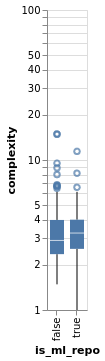

In [76]:
chart = alt.Chart(repo_merged).mark_boxplot().encode(
    x = 'is_ml_repo:O',
    y = alt.Y('complexity:Q', scale=alt.Scale(type="log"), title="complexity")
).transform_filter(
    (datum.complexity > 0)
)
chart

In [77]:
chart.save("ml-vs-complexity.png")

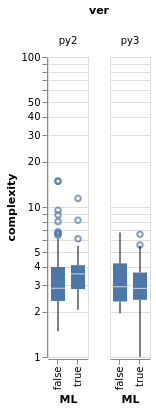

In [78]:
chart = alt.Chart(repo_merged).mark_boxplot().encode(
    x = alt.X('is_ml_repo:O', title="ML"),
    y = alt.Y('complexity:Q', scale=alt.Scale(type="log"), title="complexity"),
    column = 'ver'
).transform_filter(
    (datum.complexity > 0)
)
chart

In [79]:
chart.save("ml-vs-complexity-by-ver.png")

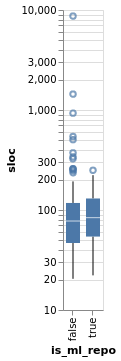

In [80]:
chart = alt.Chart(repo_merged).mark_boxplot().encode(
    x = 'is_ml_repo:O',
    y = alt.Y('sloc:Q', scale=alt.Scale(type="log"), title="sloc")
).transform_filter(
    (datum.sloc > 0)
)
chart

In [81]:
chart.save("ml-vs-sloc.png")

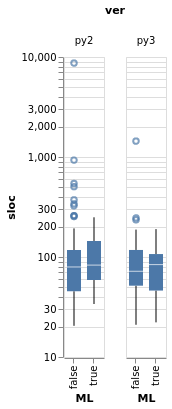

In [82]:
chart = alt.Chart(repo_merged).mark_boxplot().encode(
    x = alt.X('is_ml_repo:O', title="ML"),
    y = alt.Y('sloc:Q', scale=alt.Scale(type="log"), title="sloc"),
    column = 'ver'
).transform_filter(
    (datum.sloc > 0)
)
chart

In [83]:
chart.save("ml-vs-sloc-by-pyver.png")

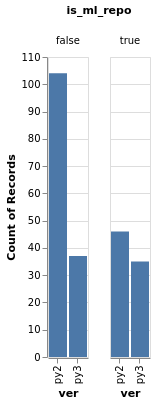

In [84]:
chart = alt.Chart(repo_merged).mark_bar().encode(
    x = 'ver',
    y = 'count()',
    column = 'is_ml_repo:O'
).transform_filter(
    (datum.sloc > 0)
)
chart

In [85]:
chart.save("ml-ver-count.png")

### Exploration of SLOC per category

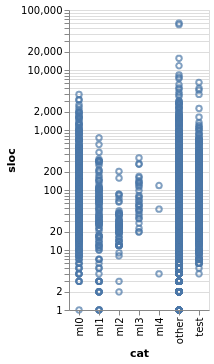

In [86]:
chart = alt.Chart(lint_df_modules_merged_simp).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('sloc', scale=alt.Scale(type="log"), title="sloc"),
).transform_filter(
    (datum.sloc > 0) # can't plot values of 0 on a log scale
)
chart

In [87]:
chart.save("sloc-vs-cat-logscale.png")

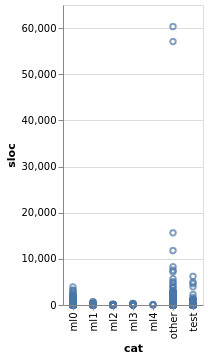

In [88]:
chart2 = alt.Chart(lint_df_modules_merged_simp).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('sloc', title="sloc")
)
chart2

In [89]:
chart.save("sloc-vs-cat.png")

Above plot is misleading: there are more repos in other category, causing it to look greater

In [90]:
lint_df_modules_merged_simp.groupby("cat").describe()["sloc"]

count        mean          std   min    25%   50%     75%      max
cat                                                                       
ml0    1157.0  173.927398   309.794133   1.0  45.00  89.0  186.00   3909.0
ml1     118.0   80.711864   114.500558   1.0  13.25  38.5   96.50    743.0
ml2      73.0   31.506849    31.026925   2.0  14.00  24.0   34.00    204.0
ml3      32.0   94.875000    78.372868  20.0  43.75  65.5  128.25    342.0
ml4       3.0   57.000000    58.025856   4.0  26.00  48.0   83.50    119.0
other  5223.0  158.205629  1222.626283   0.0  21.00  53.0  129.00  60312.0
test    759.0  163.798419   402.121643   4.0  35.00  76.0  162.00   6201.0

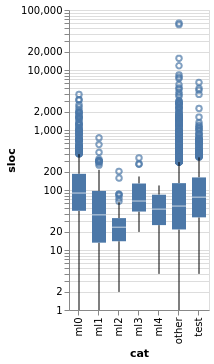

In [91]:
# Note: this cell may cause Chrome to crash (use Firefox instead)

chart4 = alt.Chart(lint_df_modules_merged_simp).mark_boxplot().encode(
    x = 'cat:O',
    y = alt.Y('sloc:Q', scale=alt.Scale(type="log"), title="sloc")
).transform_filter(
    (datum.sloc > 0)
)
chart4

In [92]:
chart.save("sloc-vs-cat-boxplot.png")

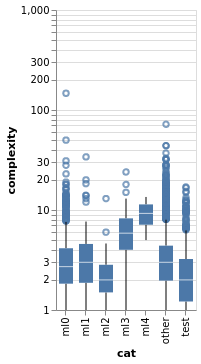

In [93]:
chart = alt.Chart(lint_df_modules_merged_simp).mark_boxplot().encode(
    x = 'cat:O',
    y = alt.Y('complexity:Q', scale=alt.Scale(type="log"), title="complexity")
).transform_filter(
    (datum.complexity > 0)
)
chart

### Exploration of differences in Pylint warnings for each category (module basis)

In [94]:
lint_df_modules_merged_simp_mean = lint_df_modules_merged_simp.groupby("cat").mean()

In [95]:
lint_df_modules_merged_simp_mean

repo  lint_abstract-class-instantiated  lint_abstract-method  \
cat                                                                           
ml0    7.055987e+07                               NaN              4.752577   
ml1    6.314698e+07                               NaN                   NaN   
ml2    3.359648e+07                               NaN                   NaN   
ml3    2.439931e+07                               NaN                   NaN   
ml4    2.146711e+07                               NaN                   NaN   
other  4.224384e+07                               3.0              3.053191   
test   3.912837e+07                               1.0              2.809524   

       lint_access-member-before-definition  \
cat                                           
ml0                                1.333333   
ml1                                     NaN   
ml2                                     NaN   
ml3                                     NaN   
ml4                                     NaN   
other                              2.178571   
test                                    NaN   

       lint_anomalous-backslash-in-string  \
cat                                         
ml0                              4.240000   
ml1                              1.750000   
ml2                                   NaN   
ml3                              1.000000   
ml4                                   NaN   
other                            5.880342   
test                             5.000000   

       lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
cat                                                                     
ml0                                        NaN               5.404372   
ml1                                        NaN               1.100000   
ml2                                        NaN                    NaN   
ml3                                        NaN                    NaN   
ml4                                        NaN                    NaN   
other                                 7.066667               2.296053   
test                                 28.571429               3.689655   

       lint_assign-to-new-keyword  lint_assigning-non-slot  \
cat                                                          
ml0                           NaN                      NaN   
ml1                           NaN                      NaN   
ml2                           NaN                      NaN   
ml3                           NaN                      NaN   
ml4                           NaN                      NaN   
other                    3.333333                      4.0   
test                          NaN                      5.0   

       lint_assignment-from-no-return  ...         ml0       ml1        ml2  \
cat                                    ...                                    
ml0                          5.407407  ...  173.812446  5.051858   0.809853   
ml1                               NaN  ...   46.372881  7.449153   5.033898   
ml2                               NaN  ...   12.780822  8.164384  45.027397   
ml3                               NaN  ...    8.562500  8.718750  53.531250   
ml4                               NaN  ...    8.000000  9.000000  57.000000   
other                        1.000000  ...   25.428871  1.761379   3.581032   
test                         4.333333  ...   83.531579  4.630263  10.977632   

             ml3       ml4       other        test       total   frac_ml  \
cat                                                                        
ml0     0.236819  0.020743  141.765774   54.783060  376.480553  0.471592   
ml1     2.364407  0.228814   89.677966   27.855932  178.983051  0.238657   
ml2    23.465753  2.342466  294.561644  114.287671  500.630137  0.059678   
ml3    28.187500  2.812500  346.125000  134.375000  582.312500  0.036028   
ml4    30.000000  3.000000  368.000000  143.000000  618.000000  0.012945   
other   1.84

n.b. ignore "repo" column (average repo id is meaningless)

In [96]:
lint_df_modules_merged_simp_mean.to_csv("lint_df_modules_merged_simp_mean.csv")

In [97]:
lint_df_modules_merged_simp_median = lint_df_modules_merged_simp.groupby("cat").median()

In [98]:
lint_df_modules_merged_simp_median

repo  lint_abstract-class-instantiated  lint_abstract-method  \
cat                                                                       
ml0    78097444                               NaN                   2.0   
ml1    70118622                               NaN                   NaN   
ml2    21467110                               NaN                   NaN   
ml3    21467110                               NaN                   NaN   
ml4    21467110                               NaN                   NaN   
other  21467110                               3.0                   1.0   
test   22354028                               1.0                   1.0   

       lint_access-member-before-definition  \
cat                                           
ml0                                     1.0   
ml1                                     NaN   
ml2                                     NaN   
ml3                                     NaN   
ml4                                     NaN   
other                                   1.0   
test                                    NaN   

       lint_anomalous-backslash-in-string  \
cat                                         
ml0                                   2.0   
ml1                                   1.5   
ml2                                   NaN   
ml3                                   1.0   
ml4                                   NaN   
other                                 2.0   
test                                  3.0   

       lint_anomalous-unicode-escape-in-string  lint_arguments-differ  \
cat                                                                     
ml0                                        NaN                    2.0   
ml1                                        NaN                    1.0   
ml2                                        NaN                    NaN   
ml3                                        NaN                    NaN   
ml4                                        NaN                    NaN   
other                                      2.0                    1.0   
test                                      14.0                    2.0   

       lint_assign-to-new-keyword  lint_assigning-non-slot  \
cat                                                          
ml0                           NaN                      NaN   
ml1                           NaN                      NaN   
ml2                           NaN                      NaN   
ml3                           NaN                      NaN   
ml4                           NaN                      NaN   
other                         2.0                      2.0   
test                          NaN                      5.0   

       lint_assignment-from-no-return  ...    ml0  ml1   ml2   ml3  ml4  \
cat                                    ...                                
ml0                               2.0  ...  282.0  3.0   0.0   0.0  0.0   
ml1                               NaN  ...    8.0  7.0   0.0   0.0  0.0   
ml2                               NaN  ...    8.0  9.0  57.0  30.0  3.0   
ml3                               NaN  ...    8.0  9.0  57.0  30.0  3.0   
ml4                               NaN  ...    8.0  9.0  57.0  30.0  3.0   
other                             1.0  ...    1.0  0.0   0.0   0.0  0.0   
test                              2.0  ...    8.0  3.0   0.0   0.0  0.0   

       other   test  total   frac_ml  is_ml_repo  
cat                                               
ml0    203.0   98.0  644.0  0.523292        True  
ml1     29.0    3.0   50.0  0.151515        True  
ml2    368.0  143.0  618.0  0.012945       False  
ml3    368.0  143.0  618.0  0.012945       False  
ml4    368.0  143.0  618.0  0.012945       False  
other  203.0   22.0  319.0  0.003409       False  
test   203.0   61.0  618.0  0.012945       False  

[7 rows x 216 columns]

In [99]:
lint_df_modules_merged_simp_median.to_csv("lint_df_modules_merged_simp_median.csv")

We "melt" the dataframe into key-value pairs for each Pylint variable to make it easier to plot the distributions without having to write queries that refer to individual Pylint variables (column names in previous dataframe):

In [100]:
melted = pd.melt(lint_df_modules_merged_simp, id_vars=["repo", "path", "cat", "sloc", "frac_ml", "is_ml_repo"])
melted

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1574917  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1574918  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1574919  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1574920  119537109       119537109/utils/text_process.py  other   74.0   
1574921  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable value  
0        0.000000       False  lint_abstract-class-instantiated   NaN  
1        0.000000       False  lint_abstract-class-instantiated   NaN  
2        0.000000       False  lint_abstract-class-instantiated   NaN  
3        0.000000       False  lint_abstract-class-instantiated   NaN  
4        0.000000       False  lint_abstract-class-instantiated   NaN  
...           ...         ...                               ...   ...  
1574917  0.291667        True                             total    72  
1574918  0.291667        True                             total    72  
1574919  0.291667        True                             total    72  
1574920  0.291667        True                             total    72  
1574921  0.291667        True                             total    72  

[1574922 rows x 8 columns]

In [101]:
melted_sanitized = melted[melted["sloc"] > 0] # ignore empty files

In [102]:
melted_sanitized

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1574917  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1574918  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1574919  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1574920  119537109       119537109/utils/text_process.py  other   74.0   
1574921  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable value  
0        0.000000       False  lint_abstract-class-instantiated   NaN  
1        0.000000       False  lint_abstract-class-instantiated   NaN  
2        0.000000       False  lint_abstract-class-instantiated   NaN  
3        0.000000       False  lint_abstract-class-instantiated   NaN  
4        0.000000       False  lint_abstract-class-instantiated   NaN  
...           ...         ...                               ...   ...  
1574917  0.291667        True                             total    72  
1574918  0.291667        True                             total    72  
1574919  0.291667        True                             total    72  
1574920  0.291667        True                             total    72  
1574921  0.291667        True                             total    72  

[1555326 rows x 8 columns]

In [103]:
melted_sanitized2 = melted_sanitized[melted_sanitized["variable"].str.startswith("lint_")]

In [104]:
melted_sanitized2

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1441825  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1441826  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1441827  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1441828  119537109       119537109/utils/text_process.py  other   74.0   
1441829  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable value  
0        0.000000       False  lint_abstract-class-instantiated   NaN  
1        0.000000       False  lint_abstract-class-instantiated   NaN  
2        0.000000       False  lint_abstract-class-instantiated   NaN  
3        0.000000       False  lint_abstract-class-instantiated   NaN  
4        0.000000       False  lint_abstract-class-instantiated   NaN  
...           ...         ...                               ...   ...  
1441825  0.291667        True        lint_wrong-import-position   NaN  
1441826  0.291667        True        lint_wrong-import-position   NaN  
1441827  0.291667        True        lint_wrong-import-position   NaN  
1441828  0.291667        True        lint_wrong-import-position   NaN  
1441829  0.291667        True        lint_wrong-import-position   NaN  

[1423890 rows x 8 columns]

In [105]:
melted_sanitized["value"].map(lambda x: type(x) == float).all()

False

In [106]:
melted_sanitized2["value"].map(lambda x: type(x) == float).all()

True

In [107]:
melted_sanitized2.dtypes

repo            int64
path           object
cat            object
sloc          float64
frac_ml       float64
is_ml_repo       bool
variable       object
value          object
dtype: object

In [108]:
melted_sanitized3 = melted_sanitized2.astype({'value': 'float64'})

In [109]:
melted_sanitized3.dtypes

repo            int64
path           object
cat            object
sloc          float64
frac_ml       float64
is_ml_repo       bool
variable       object
value         float64
dtype: object

In [110]:
melted_sanitized3

repo                                  path    cat   sloc  \
0            41590                  41590/nlp/counter.py  other  172.0   
1            41590               41590/nlp/countermap.py  other  145.0   
2            41590                      41590/nlp/crp.py  other   42.0   
3            41590              41590/nlp/cythonsetup.py  other    6.0   
4            41590            41590/nlp/distributions.py  other   64.0   
...            ...                                   ...    ...    ...   
1441825  119537109   119537109/utils/oracle/OracleGru.py    ml0  147.0   
1441826  119537109  119537109/utils/oracle/OracleLstm.py    ml0  170.0   
1441827  119537109   119537109/utils/oracle/OracleSru.py    ml0  139.0   
1441828  119537109       119537109/utils/text_process.py  other   74.0   
1441829  119537109              119537109/utils/utils.py    ml0   34.0   

          frac_ml  is_ml_repo                          variable  value  
0        0.000000       False  lint_abstract-class-instantiated    NaN  
1        0.000000       False  lint_abstract-class-instantiated    NaN  
2        0.000000       False  lint_abstract-class-instantiated    NaN  
3        0.000000       False  lint_abstract-class-instantiated    NaN  
4        0.000000       False  lint_abstract-class-instantiated    NaN  
...           ...         ...                               ...    ...  
1441825  0.291667        True        lint_wrong-import-position    NaN  
1441826  0.291667        True        lint_wrong-import-position    NaN  
1441827  0.291667        True        lint_wrong-import-position    NaN  
1441828  0.291667        True        lint_wrong-import-position    NaN  
1441829  0.291667        True        lint_wrong-import-position    NaN  

[1423890 rows x 8 columns]

To prevent crashing the browser, we filter to just the ML categories:

In [111]:
ml_run_all = melted_sanitized3[melted_sanitized3["cat"].isin(["ml0", "ml1", "ml2", "ml3", "ml4"])]

In [112]:
ml_run_subset_filt = ml_run_all.copy()

In [113]:
ml_run_subset_filt

repo                                  path  cat   sloc  \
27          118130            118130/activelearn/mmms.py  ml0  107.0   
28          118130            118130/activelearn/mmpm.py  ml0  106.0   
29          118130          118130/activelearn/oracle.py  ml0   87.0   
30          118130            118130/activelearn/qbc4.py  ml0   86.0   
31          118130        118130/activelearn/qbc_dist.py  ml0   80.0   
...            ...                                   ...  ...    ...   
1441818  119537109  119537109/utils/metrics/DocEmbSim.py  ml0  134.0   
1441825  119537109   119537109/utils/oracle/OracleGru.py  ml0  147.0   
1441826  119537109  119537109/utils/oracle/OracleLstm.py  ml0  170.0   
1441827  119537109   119537109/utils/oracle/OracleSru.py  ml0  139.0   
1441829  119537109              119537109/utils/utils.py  ml0   34.0   

          frac_ml  is_ml_repo                          variable  value  
27       0.355556        True  lint_abstract-class-instantiated    NaN  
28       0.355556        True  lint_abstract-class-instantiated    NaN  
29       0.355556        True  lint_abstract-class-instantiated    NaN  
30       0.355556        True  lint_abstract-class-instantiated    NaN  
31       0.355556        True  lint_abstract-class-instantiated    NaN  
...           ...         ...                               ...    ...  
1441818  0.291667        True        lint_wrong-import-position    NaN  
1441825  0.291667        True        lint_wrong-import-position    NaN  
1441826  0.291667        True        lint_wrong-import-position    NaN  
1441827  0.291667        True        lint_wrong-import-position    NaN  
1441829  0.291667        True        lint_wrong-import-position    NaN  

[269685 rows x 8 columns]

In [114]:
ml_run_subset_filt["normval"] = ml_run_subset_filt["value"]/ml_run_subset_filt["sloc"]

In [115]:
ml_run_subset_filt["normval"].describe()

count    12990.000000
mean         0.048656
std          0.114487
min          0.000256
25%          0.006250
50%          0.016216
75%          0.045455
max          4.500000
Name: normval, dtype: float64

In [116]:
ml_run_subset_filt["normval"][ml_run_subset_filt["normval"] > 0].describe()

count    12990.000000
mean         0.048656
std          0.114487
min          0.000256
25%          0.006250
50%          0.016216
75%          0.045455
max          4.500000
Name: normval, dtype: float64

For the purpose of plotting data on a log-scale, we replace any values of with a small number (0.00015).

In [117]:
x = ml_run_subset_filt["normval"]
ml_run_subset_filt["normval"] = x.where(x > 0.00015, other=0.00015)

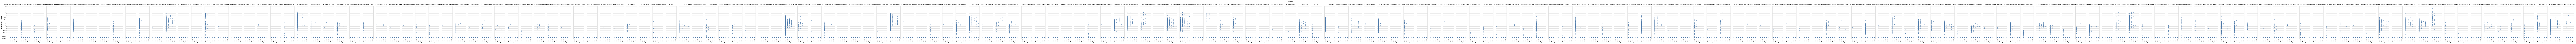

In [118]:
chart = alt.Chart(ml_run_subset_filt).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    #y = alt.Y('normval', log ),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
)
chart

In [119]:
chart.save("sloc-vs-cat-trellis.png")

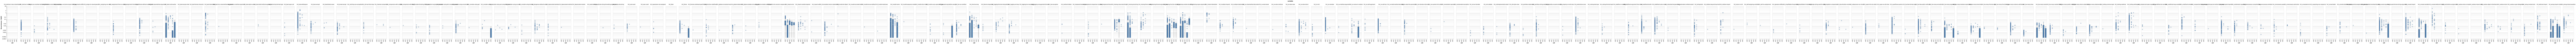

In [120]:
chart = alt.Chart(ml_run_subset_filt).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    #y = alt.Y('normval', log ),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
)
chart

In [121]:
chart.save("sloc-vs-cat-trellis-boxplot.png")

### Exploration of differences in Pylint warnings for each category (repo/category basis)

This section groups the data by repo and category prior to visualisation (e.g. repo 21467110 ML0, repo 21467110 ML1, ..., repo 21467110 other).

In theory we could use Altair/Vega-lite to aggregate/group the data, however, due to the large number of rows it tends to crash the browser.
To avoid this we manually pre-aggregate data using Pandas prior to visualising it.

In [122]:
melted_sanitized3_grouped = melted_sanitized3.groupby(["repo", "cat", "variable"]).mean()
melted_sanitized3_grouped["normval"] = melted_sanitized3_grouped["value"] / melted_sanitized3_grouped["sloc"]

In [123]:
melted_sanitized3_grouped

sloc   frac_ml  \
repo      cat   variable                                                       
41590     other lint_abstract-class-instantiated         85.350000  0.000000   
                lint_abstract-method                     85.350000  0.000000   
                lint_access-member-before-definition     85.350000  0.000000   
                lint_anomalous-backslash-in-string       85.350000  0.000000   
                lint_anomalous-unicode-escape-in-string  85.350000  0.000000   
...                                                            ...       ...   
119537109 other lint_useless-super-delegation            58.363636  0.291667   
                lint_using-constant-test                 58.363636  0.291667   
                lint_wildcard-import                     58.363636  0.291667   
                lint_wrong-import-order                  58.363636  0.291667   
                lint_wrong-import-position               58.363636  0.291667   

                                                         is_ml_repo  value  \
repo      cat   variable                                                     
41590     other lint_abstract-class-instantiated              False    NaN   
                lint_abstract-method                          False    NaN   
                lint_access-member-before-definition          False    NaN   
                lint_anomalous-backslash-in-string            False    5.0   
                lint_anomalous-unicode-escape-in-string       False    NaN   
...                                                             ...    ...   
119537109 other lint_useless-super-delegation                  True    NaN   
                lint_using-constant-test                       True    NaN   
                lint_wildcard-import                           True    1.0   
                lint_wrong-import-order                        True    1.0   
                lint_wrong-import-position                     True    NaN   

                                                          normval  
repo      cat   variable                                           
41590     other lint_abstract-class-instantiated              NaN  
                lint_abstract-method                          NaN  
                lint_access-member-before-definition          NaN  
                lint_anomalous-backslash-in-string       0.058582  
                lint_anomalous-unicode-escape-in-string       NaN  
...                                                           ...  
119537109 other lint_useless-super-delegation                 NaN  
                lint_using-constant-test                      NaN  
                lint_wildcard-import                     0.017134  
                lint_wrong-import-order                  0.017134  
                lint_wrong-import-position                    NaN  

[81120 rows x 5 columns]

In [124]:
melted_sanitized3_grouped["normval"].describe()

count    9569.000000
mean        0.050244
std         0.218337
min         0.000115
25%         0.009699
50%         0.018018
75%         0.040404
max        16.087034
Name: normval, dtype: float64

In [125]:
melted_sanitized3_grouped[melted_sanitized3_grouped["sloc"] == 0]

Empty DataFrame
Columns: [sloc, frac_ml, is_ml_repo, value, normval]
Index: []

In [126]:
melted_sanitized3_grouped_flat = pd.DataFrame(melted_sanitized3_grouped.to_records())

In [127]:
melted_sanitized3_grouped_flat

repo    cat                                 variable       sloc  \
0          41590  other         lint_abstract-class-instantiated  85.350000   
1          41590  other                     lint_abstract-method  85.350000   
2          41590  other     lint_access-member-before-definition  85.350000   
3          41590  other       lint_anomalous-backslash-in-string  85.350000   
4          41590  other  lint_anomalous-unicode-escape-in-string  85.350000   
...          ...    ...                                      ...        ...   
81115  119537109  other            lint_useless-super-delegation  58.363636   
81116  119537109  other                 lint_using-constant-test  58.363636   
81117  119537109  other                     lint_wildcard-import  58.363636   
81118  119537109  other                  lint_wrong-import-order  58.363636   
81119  119537109  other               lint_wrong-import-position  58.363636   

        frac_ml  is_ml_repo  value   normval  
0      0.000000       False    NaN       NaN  
1      0.000000       False    NaN       NaN  
2      0.000000       False    NaN       NaN  
3      0.000000       False    5.0  0.058582  
4      0.000000       False    NaN       NaN  
...         ...         ...    ...       ...  
81115  0.291667        True    NaN       NaN  
81116  0.291667        True    NaN       NaN  
81117  0.291667        True    1.0  0.017134  
81118  0.291667        True    1.0  0.017134  
81119  0.291667        True    NaN       NaN  

[81120 rows x 8 columns]

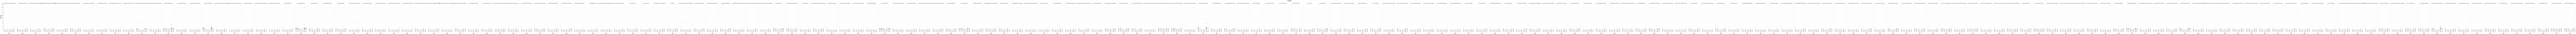

In [128]:
# This plot can crash Chrome browser (use Firefox instead)

chart = alt.Chart(melted_sanitized3_grouped_flat).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normval'),
    column = 'variable'
)
chart

In [129]:
chart.save("normval-vs-cat-trellis.png")

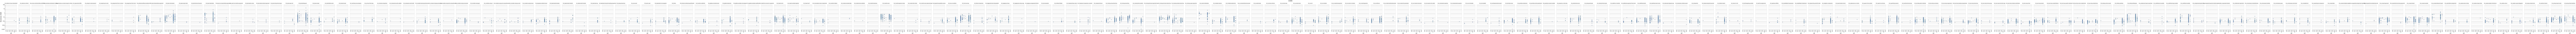

In [130]:
chart = alt.Chart(melted_sanitized3_grouped_flat).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_filter(
    (datum.normval > 0)
)
chart

In [131]:
chart.save("normval-vs-cat-trellis-logscale.png")

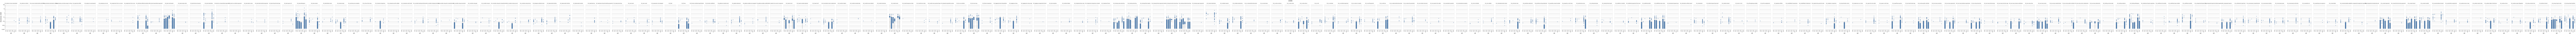

In [132]:
chart = alt.Chart(melted_sanitized3_grouped_flat).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
#.transform_filter(
    #(datum.normval > 0)
#)
chart

In [133]:
chart.save("normval-vs-cat-trellis-logscale-boxplot.png")

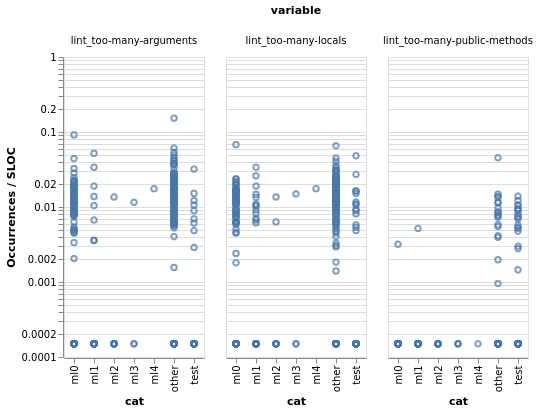

In [193]:
chart = alt.Chart(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["variable"].isin(["lint_too-many-locals", "lint_too-many-arguments", "lint_too-many-public-methods"])]).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

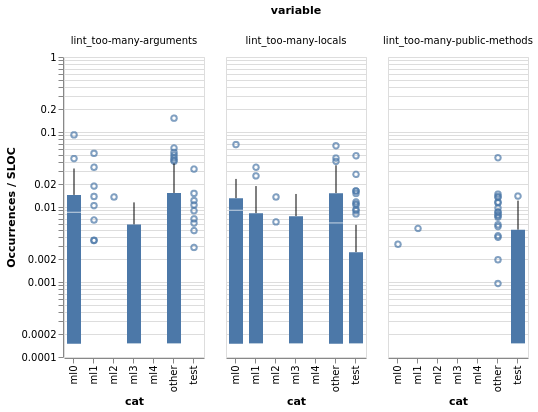

In [196]:
chart = alt.Chart(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["variable"].isin(["lint_too-many-locals", "lint_too-many-arguments", "lint_too-many-public-methods"])]).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

In [197]:
chart.save("normval-vs-cat-trellis-logscale-boxplot-significant.png")

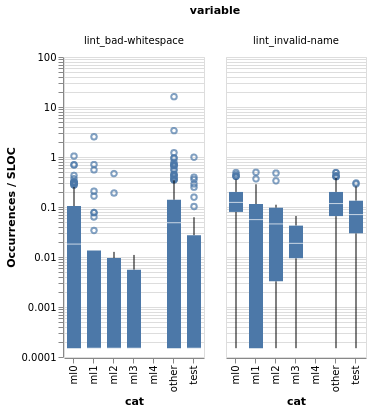

In [198]:
chart = alt.Chart(melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["variable"].isin(["lint_bad-whitespace", "lint_invalid-name"])]).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

In [199]:
chart.save("normval-vs-cat-trellis-logscale-boxplot-interesting.png")

### Controlling for Repo Depth

Only some (typically large) repos have ML code with 3 to 4 layers of indirection. This could lead to bias (as the repos in the ML 3 and ML 4 categories are special). This section first filters repos to only those that contain code in each category so that all categories display data across the same sample.

(All selected repos will have a ML0, ML1, and ML2 cat. We also show the other categories -- but some of these may have an uneven number of datapoints, so should be interpreted with more caution)

In [134]:
deep_repos = melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["cat"] == "ml2"].repo.unique()

In [135]:
deep_repos

array([ 21467110,  24100479,  43172794,  46331578,  52581991,  70118622,
        95985462, 103471501, 112664267, 114098658])

In [136]:
melted_sanitized3_grouped_flat_deeponly = melted_sanitized3_grouped_flat[melted_sanitized3_grouped_flat["repo"].isin(deep_repos)]
melted_sanitized3_grouped_flat_deeponly = melted_sanitized3_grouped_flat_deeponly.fillna(0)

In [137]:
melted_sanitized3_grouped_flat_deeponly

repo    cat                                 variable     sloc  \
23985   21467110    ml0         lint_abstract-class-instantiated  267.375   
23986   21467110    ml0                     lint_abstract-method  267.375   
23987   21467110    ml0     lint_access-member-before-definition  267.375   
23988   21467110    ml0       lint_anomalous-backslash-in-string  267.375   
23989   21467110    ml0  lint_anomalous-unicode-escape-in-string  267.375   
...          ...    ...                                      ...      ...   
79555  114098658  other            lint_useless-super-delegation   95.000   
79556  114098658  other                 lint_using-constant-test   95.000   
79557  114098658  other                     lint_wildcard-import   95.000   
79558  114098658  other                  lint_wrong-import-order   95.000   
79559  114098658  other               lint_wrong-import-position   95.000   

        frac_ml  is_ml_repo  value   normval  
23985  0.012945       False    0.0  0.000000  
23986  0.012945       False    0.0  0.000000  
23987  0.012945       False    0.0  0.000000  
23988  0.012945       False    1.0  0.003740  
23989  0.012945       False    0.0  0.000000  
...         ...         ...    ...       ...  
79555  0.619048        True    0.0  0.000000  
79556  0.619048        True    1.0  0.010526  
79557  0.619048        True    0.0  0.000000  
79558  0.619048        True    5.0  0.052632  
79559  0.619048        True    0.0  0.000000  

[9750 rows x 8 columns]

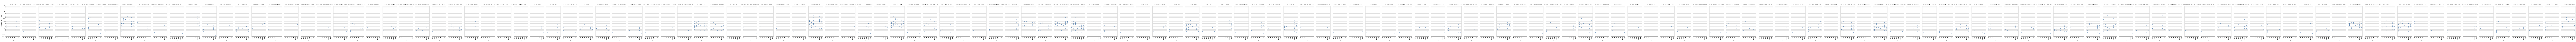

In [138]:
chart = alt.Chart(melted_sanitized3_grouped_flat_deeponly).mark_point().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_filter(
    (datum.normval > 0)
)
chart

In [139]:
chart.save("normval-vs-cat-trellis-logscale-deeponly.png")

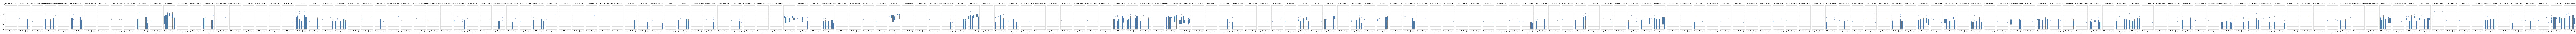

In [140]:
chart = alt.Chart(melted_sanitized3_grouped_flat_deeponly).mark_boxplot().encode(
    x = alt.X('cat', type='nominal'),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    column = 'variable'
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

In [141]:
chart.save("normval-vs-cat-trellis-logscale-boxplot-deeponly.png")

### Exploration of differences in Pylint warnings for each category (repo basis)

This section groups the data by repo prior to visualisation (e.g. repo 21467110). The entire repo is marked as ML or non-ML (based on the fraction of ML modules in the repo).

In [142]:
melted_sanitized3_grouped_repo = melted_sanitized3.groupby(["repo", "variable"]).mean()
melted_sanitized3_grouped_repo["normval"] = melted_sanitized3_grouped_repo["value"] / melted_sanitized3_grouped_repo["sloc"]
melted_sanitized3_grouped_repo = melted_sanitized3_grouped_repo.fillna(0)
melted_sanitized3_grouped_repoflat = pd.DataFrame(melted_sanitized3_grouped_repo.to_records())

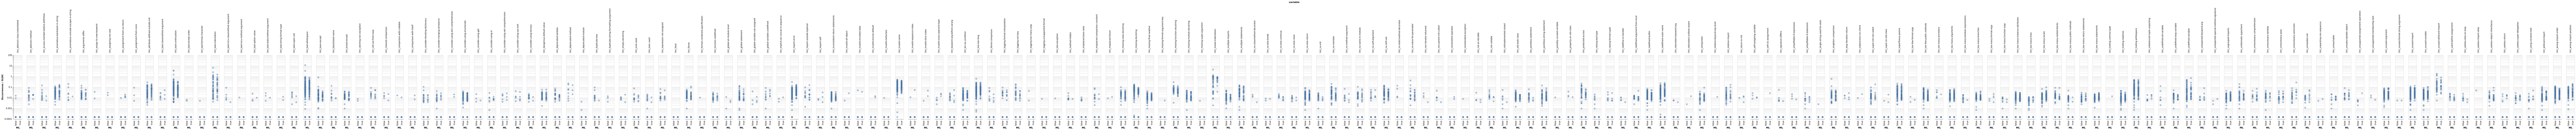

In [143]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).facet(
    column = 'variable:N'
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

In [144]:
chart.save("normval-vs-ml-trellis.png")

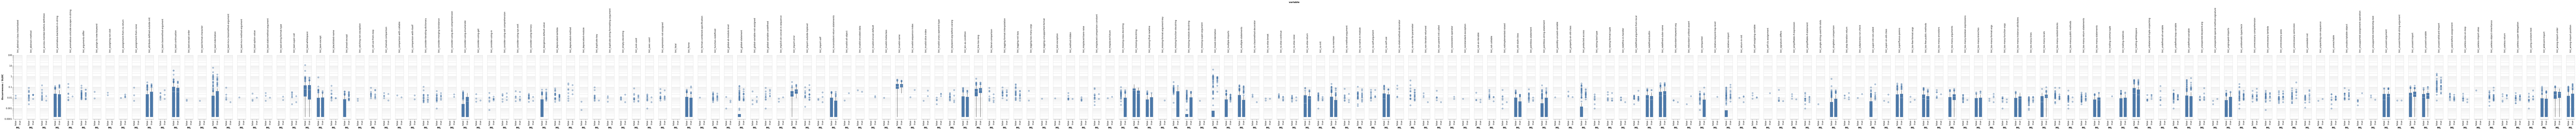

In [145]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_boxplot().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).facet(
    column = 'variable:N'
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.00015)'
)
chart

In [146]:
chart.save("normval-vs-ml-trellis-boxplot.png")

Individual Plots (for paper)

In [168]:
melted_sanitized3_grouped_repoflat[variable]

repo                                 variable        sloc  \
0          41590         lint_abstract-class-instantiated   92.259259   
1          41590                     lint_abstract-method   92.259259   
2          41590     lint_access-member-before-definition   92.259259   
3          41590       lint_anomalous-backslash-in-string   92.259259   
4          41590  lint_anomalous-unicode-escape-in-string   92.259259   
...          ...                                      ...         ...   
43090  119537109            lint_useless-super-delegation  134.294118   
43091  119537109                 lint_using-constant-test  134.294118   
43092  119537109                     lint_wildcard-import  134.294118   
43093  119537109                  lint_wrong-import-order  134.294118   
43094  119537109               lint_wrong-import-position  134.294118   

        frac_ml  is_ml_repo     value   normval  
0      0.000000       False  0.000000  0.000000  
1      0.000000       False  0.000000  0.000000  
2      0.000000       False  0.000000  0.000000  
3      0.000000       False  5.000000  0.054195  
4      0.000000       False  0.000000  0.000000  
...         ...         ...       ...       ...  
43090  0.291667        True  0.000000  0.000000  
43091  0.291667        True  0.000000  0.000000  
43092  0.291667        True  1.222222  0.009101  
43093  0.291667        True  1.000000  0.007446  
43094  0.291667        True  0.000000  0.000000  

[43095 rows x 7 columns]

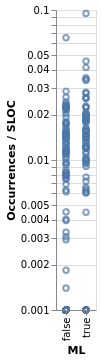

In [182]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.001)'
).transform_filter(
    datum.variable=='lint_too-many-locals'
)
chart

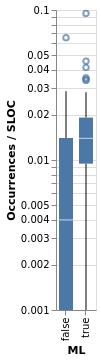

In [183]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_boxplot().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.001)'
).transform_filter(
    datum.variable=='lint_too-many-locals'
)
chart

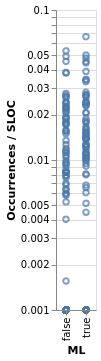

In [184]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.001)'
).transform_filter(
    datum.variable=='lint_too-many-arguments'
)
chart

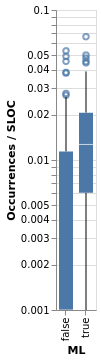

In [185]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_boxplot().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.001)'
).transform_filter(
    datum.variable=='lint_too-many-arguments'
)
chart

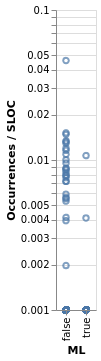

In [186]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.001)'
).transform_filter(
    datum.variable=='lint_too-many-public-methods'
)
chart

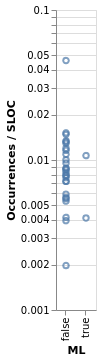

In [187]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_boxplot().encode(
    x = alt.X('is_ml_repo', type='nominal', title="ML"),
    y = alt.Y('normvalsafe:Q', scale=alt.Scale(type="log"), title="Occurrences / SLOC")
).configure(
    header = alt.HeaderConfig(labelAngle = -90)
).transform_calculate(
    normvalsafe='max(datum.normval, 0.001)'
).transform_filter(
    datum.variable=='lint_too-many-public-methods'
)
chart

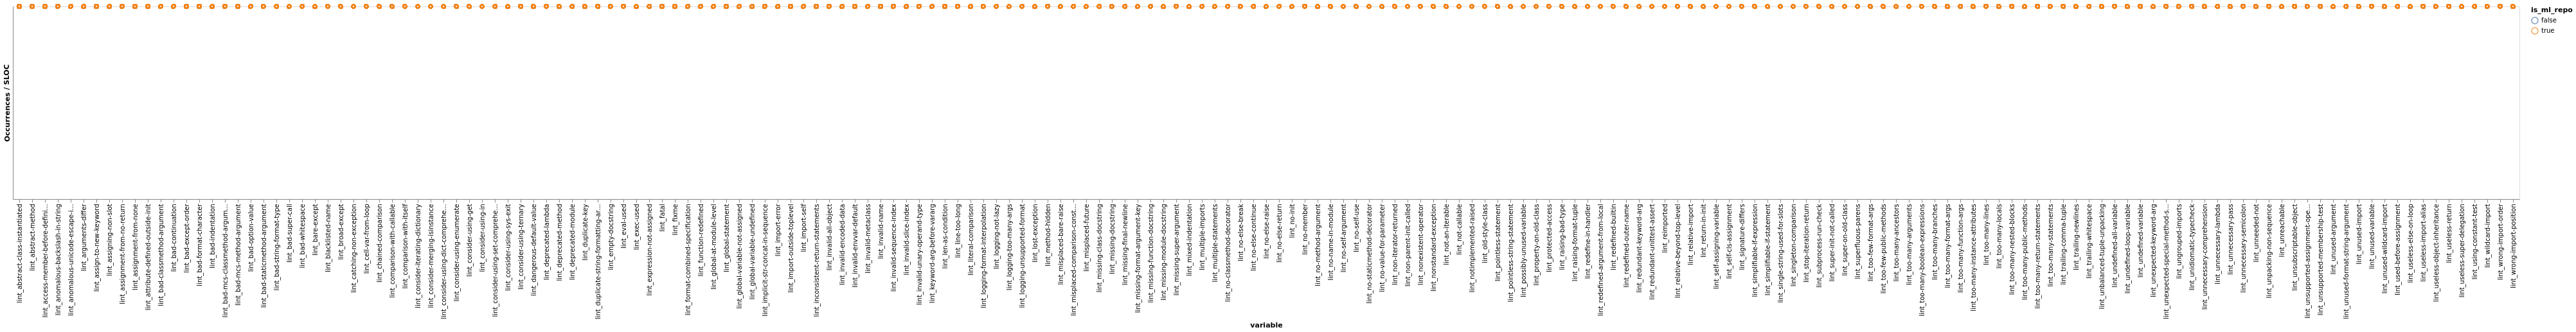

In [147]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = 'variable',
    y = alt.Y('normval', scale=alt.Scale(type="log"), title="Occurrences / SLOC"),
    color = 'is_ml_repo'
)
chart

In [148]:
chart.save("normval-vs-ml-colour.png")

In [149]:
# following https://vega.github.io/vega-lite/examples/circle_natural_disasters.html
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    x = alt.X('variable', type='ordinal'),
    y = alt.Y('value', scale=alt.Scale(type="log"), title="Issues / SLOC"),
    color = alt.Color('repo', type='nominal', legend=alt.Legend(title="repo", orient="bottom")),
    row = 'is_ml_repo'
).transform_filter(
    (datum.normval > 0)
)

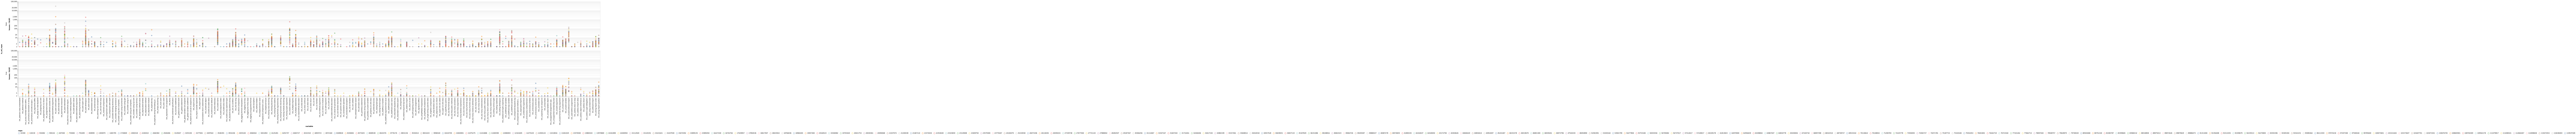

In [150]:
chart

In [151]:
chart.save("normval-vs-ml-repo-colour.png")

In [152]:
# TODO: prevent plotting multiple points for each pylint variable

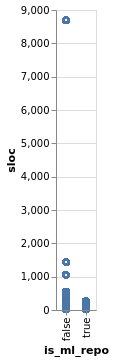

In [153]:
chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
    y = alt.Y('sloc', title="sloc"),
    x = 'is_ml_repo'
)
chart

In [154]:
chart.save("sloc-vs-ml.png")

In [155]:
melted_sanitized3_grouped_repoflat

repo                                 variable        sloc  \
0          41590         lint_abstract-class-instantiated   92.259259   
1          41590                     lint_abstract-method   92.259259   
2          41590     lint_access-member-before-definition   92.259259   
3          41590       lint_anomalous-backslash-in-string   92.259259   
4          41590  lint_anomalous-unicode-escape-in-string   92.259259   
...          ...                                      ...         ...   
43090  119537109            lint_useless-super-delegation  134.294118   
43091  119537109                 lint_using-constant-test  134.294118   
43092  119537109                     lint_wildcard-import  134.294118   
43093  119537109                  lint_wrong-import-order  134.294118   
43094  119537109               lint_wrong-import-position  134.294118   

        frac_ml  is_ml_repo     value   normval  
0      0.000000       False  0.000000  0.000000  
1      0.000000       False  0.000000  0.000000  
2      0.000000       False  0.000000  0.000000  
3      0.000000       False  5.000000  0.054195  
4      0.000000       False  0.000000  0.000000  
...         ...         ...       ...       ...  
43090  0.291667        True  0.000000  0.000000  
43091  0.291667        True  0.000000  0.000000  
43092  0.291667        True  1.222222  0.009101  
43093  0.291667        True  1.000000  0.007446  
43094  0.291667        True  0.000000  0.000000  

[43095 rows x 7 columns]

In [156]:
#chart = alt.Chart(melted_sanitized3_grouped_repoflat).mark_point().encode(
#    y = alt.Y('complexity', title="complexity"),
#    x = 'is_ml_repo'
#)
#chart

## Which differences between ML repos and non-ML repos are statistically significant?

In [157]:
def one_way_test(a, b, rowname="row"):
    meana = np.mean(a)
    meda = np.median(a)
    stda = np.std(a, ddof=1) # sample SD
    meanb = np.mean(b)
    medb = np.median(b)
    stdb = np.std(b, ddof=1) # sample SD
    # f-test (one-way ANOVA)
    f_stat, f_pval = stats.f_oneway(a, b)
    # kruskal (non-parametric equivalent to the ANOVA testing difference of median)
    try:
        k_stat, k_pval = stats.kruskal(a, b)
    except ValueError as e:
        print("WARN: Row {}: {}".format(rowname, str(e)))
        k_stat, k_pval = (np.nan, np.nan)
    # mannwhitneyu (rank test on independent samples)
    # Disclaimer: "Use only when the number of observation in each sample is > 20"
    try:
        u_stat, u_pval = stats.mannwhitneyu(a, b)
    except ValueError as e:
        print("WARN: Row {}: {}".format(rowname, str(e)))
        u_stat, u_pval = (np.nan, np.nan)
    # TODO: consider Fisher's exact test on errors-vs-non-errors
    
    return [rowname, meana, meda, stda, meanb, medb, stdb, f_stat, f_pval, k_stat, k_pval, u_stat, u_pval]

In [158]:
melted_sanitized3_grouped_repoflat_filled = melted_sanitized3_grouped_repoflat.fillna(0)

In [159]:
melted_sanitized3_grouped_repoflat_filled

repo                                 variable        sloc  \
0          41590         lint_abstract-class-instantiated   92.259259   
1          41590                     lint_abstract-method   92.259259   
2          41590     lint_access-member-before-definition   92.259259   
3          41590       lint_anomalous-backslash-in-string   92.259259   
4          41590  lint_anomalous-unicode-escape-in-string   92.259259   
...          ...                                      ...         ...   
43090  119537109            lint_useless-super-delegation  134.294118   
43091  119537109                 lint_using-constant-test  134.294118   
43092  119537109                     lint_wildcard-import  134.294118   
43093  119537109                  lint_wrong-import-order  134.294118   
43094  119537109               lint_wrong-import-position  134.294118   

        frac_ml  is_ml_repo     value   normval  
0      0.000000       False  0.000000  0.000000  
1      0.000000       False  0.000000  0.000000  
2      0.000000       False  0.000000  0.000000  
3      0.000000       False  5.000000  0.054195  
4      0.000000       False  0.000000  0.000000  
...         ...         ...       ...       ...  
43090  0.291667        True  0.000000  0.000000  
43091  0.291667        True  0.000000  0.000000  
43092  0.291667        True  1.222222  0.009101  
43093  0.291667        True  1.000000  0.007446  
43094  0.291667        True  0.000000  0.000000  

[43095 rows x 7 columns]

In [160]:
rows = []
for factor, factor_data in melted_sanitized3_grouped_repoflat_filled.groupby("variable"):
    a = factor_data["normval"][(factor_data["is_ml_repo"] == True)]
    b = factor_data["normval"][(factor_data["is_ml_repo"] == False)]
    row = one_way_test(a, b, rowname=factor)
    rows.append(row)

/home/andrew/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3235: RuntimeWarning: invalid value encountered in double_scalars
  f = msb / msw


WARN: Row lint_fatal: All numbers are identical in kruskal
WARN: Row lint_fatal: All numbers are identical in mannwhitneyu


Comparison of factors (lint errrors), after normalizing for SLOC

In [161]:
df = pd.DataFrame.from_records(rows, columns=["factor", "meana", "meda", "stda", "meanb", "medb", "stdb", "f_stat", "f_pval", "k_stat", "k_pval", "u_stat", "u_pval"])

In [162]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [163]:
df.sort_values("k_pval")

factor     meana      meda      stda  \
154                       lint_too-many-locals  0.015399  0.013953  0.013074   
59                           lint_import-error  0.047887  0.040650  0.030598   
147                    lint_too-many-arguments  0.014986  0.012697  0.013494   
85                      lint_missing-docstring  0.024430  0.024932  0.024432   
156               lint_too-many-public-methods  0.000183  0.000000  0.001268   
34               lint_consider-using-enumerate  0.006910  0.004484  0.008601   
158                   lint_too-many-statements  0.006282  0.006055  0.007383   
152          lint_too-many-instance-attributes  0.008496  0.007884  0.007802   
141                 lint_super-init-not-called  0.003555  0.000000  0.020281   
73                          lint_line-too-long  0.062199  0.052356  0.052108   
148          lint_too-many-boolean-expressions  0.000074  0.000000  0.000669   
88             lint_missing-function-docstring  0.019418  0.000000  0.027687   
92                       lint_multiple-imports  0.002152  0.000000  0.004824   
182                         lint_unused-import  0.026899  0.020513  0.024696   
128                            lint_reimported  0.004528  0.000000  0.011332   
89               lint_missing-module-docstring  0.006226  0.000000  0.009577   
115                   lint_pointless-statement  0.000262  0.000000  0.001412   
170             lint_unnecessary-comprehension  0.002637  0.000000  0.009007   
44                          lint_duplicate-key  0.000067  0.000000  0.000599   
168                     lint_ungrouped-imports  0.006284  0.000000  0.008638   
183                       lint_unused-variable  0.019219  0.015823  0.018889   
120                      lint_raising-bad-type  0.000000  0.000000  0.000000   
155                lint_too-many-nested-blocks  0.002286  0.000000  0.009900   
99                                lint_no-init  0.000396  0.000000  0.001833   
114                       lint_old-style-class  0.003070  0.000000  0.005701   
188            lint_useless-object-inheritance  0.003834  0.000000  0.011605   
8               lint_assignment-from-no-return  0.000694  0.000000  0.003158   
39                 lint_consider-using-ternary  0.000205  0.000000  0.001399   
82          lint_misplaced-comparison-constant  0.000357  0.000000  0.002511   
62         lint_inconsistent-return-statements  0.003276  0.000000  0.006521   
163                lint_undefined-all-variable  0.000000  0.000000  0.000000   
109                  lint_nonexistent-operator  0.000240  0.000000  0.001560   
20                 lint_bad-string-format-type  0.000227  0.000000  0.001516   
65                 lint_invalid-envvar-default  0.000303  0.000000  0.001933   
33      lint_consider-using-dict-comprehension  0.000397  0.000000  0.002594   
30                 lint_comparison-with-itself  0.000284  0.000000  0.001934   
143                    lint_superfluous-parens  0.022781  0.009583  0.037500   
2         lint_access-member-before-definition  0.000235  0.000000  0.001634   
106                lint_no-value-for-parameter  0.003850  0.000000  0.010456   
81                   lint_misplaced-bare-raise  0.000000  0.000000  0.000000   
116            lint_pointless-string-statement  0.006987  0.000000  0.012966   
171                    lint_unnecessary-lambda  0.001396  0.000000  0.005108   
84                lint_missing-class-docstring  0.006423  0.000000  0.011437   
60                lint_import-outside-toplevel  0.004793  0.000000  0.018985   
80                          lint_method-hidden  0.000093  0.000000  0.000836   
153                        lint_too-many-lines  0.000650  0.000000  0.002296   
131                        lint_return-in-init  0.000359  0.000000  0.002014   
150                  lint_too-many-format-args  0.000628  0.000000  0.003160   
5                        lint_arguments-differ  0.003406  0.000000  0.010326   
100                             lint_no-

In [164]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

In [165]:
df.to_csv("pylint_ml_significance.csv")